# III Analysis of genetic factors asscoaited with phenotypic heterogeneity

##### - distribution of inheritance patterns of two associated diseases
##### - distribution of variants with 2 associated phenotypes
##### - constraint metrics (pLI, LOEUF)
##### - phenotypic similarity of 2 diseases associated with common casual gene
##### - statistical analysis of  within-gene distribution and type of variants

# Library

## Load Python libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import rpy2

### Python libraries for scripts 

In [4]:
import argparse
import subprocess
import maths
import csv

from pyhpo import HPOSet, Ontology
from pybedtools import BedTool
from itertools import zip_longest

## Load R and R packages 

In [3]:
%load_ext rpy2.ipython
#%reload_ext rpy2.ipython

In [4]:
%%R
library(dplyr)
library(tidyr)
library(ggplot2)
library(scales)
library(qqman)
library(hexbin)
library(RColorBrewer)
library(enrichplot)
library(clusterProfiler)
library(msigdbr)
library(gridExtra)
library(tidyverse)

R[write to console]: 
Присоединяю пакет: ‘dplyr’


R[write to console]: Следующие объекты скрыты от ‘package:stats’:

    filter, lag


R[write to console]: Следующие объекты скрыты от ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: 

R[write to console]: For example usage please run: vignette('qqman')

R[write to console]: 

R[write to console]: Citation appreciated but not required:

R[write to console]: Turner, (2018). qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. Journal of Open Source Software, 3(25), 731, https://doi.org/10.21105/joss.00731.

R[write to console]: 

R[write to console]: Registered S3 method overwritten by 'enrichplot':
  method               from
  fortify.enrichResult DOSE

R[write to console]: clusterProfiler v3.14.3  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He

# Load data and select genes linked to exactly 2 monogenic diseases

In [15]:
df_m = pd.read_csv('./Clinvar_grch38_20230326_PLP_HPO_MIMcount.csv', sep='\t')
df_m.head(3)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,GENE,CLNSIG,MC,OMIM,Inheritance,Ensembl,MIMs_per_Gene
0,chr1,1013983,1028857,G,A,-10.0,PASS,ISG15,Pathogenic,splice_acceptor_variant,OMIM:616126,AR,ENSG00000187608,1
1,chr1,1014143,183381,C,T,-10.0,PASS,ISG15,Pathogenic,nonsense,OMIM:616126,AR,ENSG00000187608,1
2,chr1,1014316,161455,C,CG,-10.0,PASS,ISG15,Pathogenic,frameshift_variant,OMIM:616126,AR,ENSG00000187608,1


In [16]:
# Subset and count genes with 2 associated diseases

df_2dis = df_m[df_m['MIMs_per_Gene'] == 2]
print('N of genes associated with 2 diseases:',df_2dis['GENE'].drop_duplicates().shape[0])

N of genes associated with 2 diseases: 530


## Distribution of inheritance patterns of 2 diseases linked to one gene

In [23]:
df_2dis = df_m[df_m['MIMs_per_Gene'] == 2]

In [24]:
g2ph_list = df_2dis[['GENE','Ensembl','OMIM', 'Inheritance']].drop_duplicates()

# rm rows wo inheritance data
g2ph_list = g2ph_list[g2ph_list['Inheritance'].notna()]
g2ph_list = g2ph_list.loc[g2ph_list.duplicated(subset='GENE', keep=False)]
g2ph_list

,GENE,Ensembl,OMIM,Inheritance
47,DVL1,ENSG00000107404,OMIM:616331,AD
59,DVL1,ENSG00000107404,OMIM:180700,AD
69,ATAD3A,ENSG00000197785,OMIM:618810,AR
72,ATAD3A,ENSG00000197785,OMIM:617183,ADAR
99,PEX10,ENSG00000157911,OMIM:614871,AR
...,...,...,...,...
87572,OPN1MW,ENSG00000268221,OMIM:303800,XL
87950,RAB39B,ENSG00000155961,OMIM:311510,XL
87953,RAB39B,ENSG00000155961,OMIM:300271,XL
87957,SRY,ENSG00000184895,OMIM:400044,YL


In [25]:
inh_class = g2ph_list.groupby(['GENE', 'Ensembl', 'Inheritance']).size().reset_index(name='class')

In [26]:
inh_class.head(10)

,GENE,Ensembl,Inheritance,class
0,ABCA1,ENSG00000165029,AD,1
1,ABCA1,ENSG00000165029,AR,1
2,ABCA12,ENSG00000144452,AR,2
3,ABCB11,ENSG00000073734,AR,2
4,ACAN,ENSG00000157766,AD,1
5,ACAN,ENSG00000157766,AR,1
6,ACO2,ENSG00000100412,AR,2
7,ACTG1,ENSG00000184009,AD,2
8,ACTG2,ENSG00000163017,AD,2
9,ADA2,ENSG00000093072,AR,2


In [27]:
def compute_class(df):    
    
    if (df['class'] == 2) & (df['Inheritance'] == 'AR'):
        return '2AR'
    
    elif (df['class'] == 2) & (df['Inheritance'] == 'AD'):
        return '2AD'
    
    elif (df['class'] == 2) & (df['Inheritance'] == 'XL'):
        return '2XL'
    
    elif (df['class'] == 2) & (df['Inheritance'] == 'YL'):
        return '2YL'
    
    elif df['GENE'] == 'SRY':
        return 'YL'
    
    elif ((df['class'] == 1) & (df['GENE'] != 'SRY')) | (df['Inheritance'] == 'ADAR'):
        return 'ADAR'
    
    else:
        return 'NA'

In [28]:
inh_class['Inh_class'] = inh_class.apply(compute_class, axis = 1)
inh_class = inh_class.drop(columns=['class'])

In [29]:
# Plot
inh_dat = inh_class[['GENE','Ensembl', 'Inh_class']].drop_duplicates()
inh_dat.to_csv('./interm/Gene2Pheno_Inh.csv', sep='\t', index=False)

In [30]:
%%R -i inh_dat 

inh_dat <- as.data.frame(table(inh_dat$Inh_class))
inh_dat

  Var1 Freq
1  2AD  149
2  2AR  167
3  2XL   36
4 ADAR  176
5   YL    1


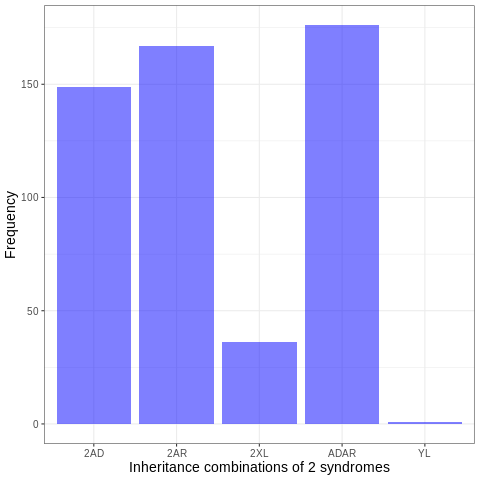

In [31]:
%%R

inh_pl <- ggplot(inh_dat, aes(x=Var1, y=Freq)) + geom_bar(stat = 'identity', fill='blue', alpha=0.5) + theme_bw() + theme(axis.text = element_text(size = 10), axis.title =  element_text(size=14)) + xlab('Inheritance combinations of 2 syndromes') + ylab('Frequency')
inh_pl

## Distribution of variants with 2 annotated diseases

In [4]:
sumvarpheno = pd.read_csv('./interm/SumVarPheno.csv', sep='\t')
sumvarpheno.head(2)

,MIMs_per_Gene,GENE,Variants_with_MultiMIMs,N_variants,Percent
0,2,ABCA1,1,18,100.0
1,2,ABCA12,1,12,80.0


In [5]:
sumvarpheno[sumvarpheno['MIMs_per_Gene'] ==2].drop_duplicates(['GENE']).shape

(530, 5)

In [103]:
inh_class.head(2) 

,GENE,Inh_class
0,ABCA1,ADAR
2,ABCA12,2AR


In [104]:
inh_class = inh_class[['GENE', 'Inh_class']].drop_duplicates()

In [7]:
sumgph2 = sumvarpheno[sumvarpheno['MIMs_per_Gene'] ==2]
sumgph2.drop_duplicates(['GENE']).shape

(530, 5)

In [106]:
sumgph2 = sumgph2.merge(inh_class, on=['GENE'], how='left')
sumgph2.shape

(907, 6)

In [40]:
#sumgph2.to_csv('sumgph2_for_plot.csv', sep=',', index=False)

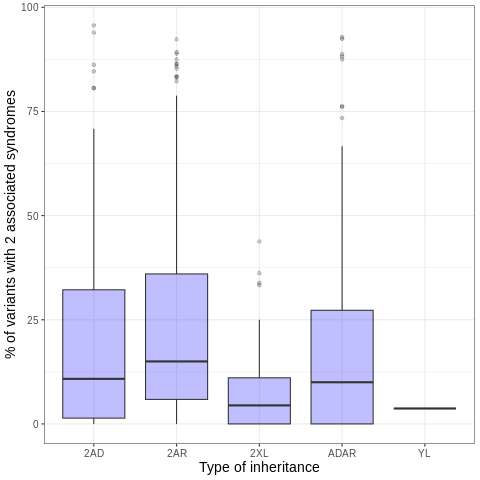

In [39]:
%%R -i sumgph2

ph2_box <- ggplot(sumgph2[sumgph2$Variants_with_MultiMIMs == 1, ], aes(x=Inh_class, y=100-Percent)) + geom_boxplot(fill='blue', alpha=0.25) + theme_bw() + theme(axis.text = element_text(size = 10), axis.title =  element_text(size=14)) + xlab('Type of inheritance') + ylab('% of variants with 2 associated syndromes')
ph2_box

In [11]:
# genes with >=50 pleiotropic variants
sumgph2_50 = sumgph2[(sumgph2.MIMs_per_Gene ==2) & (sumgph2.Variants_with_MultiMIMs == 2) & (sumgph2.Percent >50)]
sumgph2_50.to_csv('./interm/G2Ph_pleiotvar_50.csv', sep='\t', index=False)
sumgph2_50.shape

(69, 5)

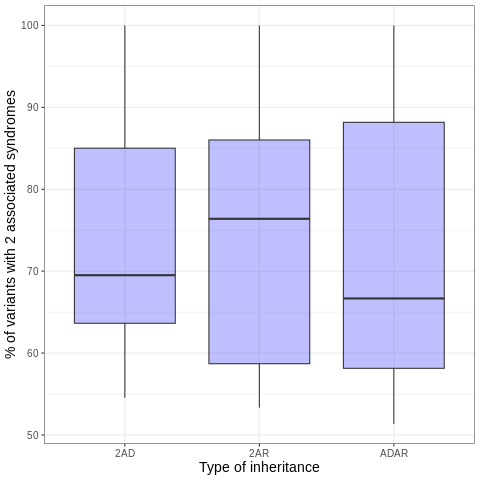

In [125]:
%%R -i sumgph2_50
ph2_50_box <- ggplot(sumgph2_50[sumgph2_50$Variants_with_MultiMIMs == 2, ], aes(x=Inh_class, y=Percent)) + geom_boxplot(fill='blue', alpha=0.25) + theme_bw() + theme(axis.text = element_text(size = 10), axis.title =  element_text(size=14)) + xlab('Type of inheritance') + ylab('% of variants with 2 associated syndromes')
ph2_50_box

## Constraint metrics

In [63]:
%%R

# pLI and loeuf scores from gnomAD

gnomad <- read.csv('./data/gnomad.v2.1.1.pli_loeuf.txt', sep='\t', header=TRUE)
head(gnomad)

   gene pLI oe_lof_upper oe_lof_upper_bin
1 MED13   1        0.030                0
2 NIPBL   1        0.032                0
3  SMC3   1        0.037                0
4 CNOT1   1        0.038                0
5   RLF   1        0.040                0
6 PCF11   1        0.040                0


### pLI

In [64]:
%%R

# select pLI
gn_pLI <- gnomad[ ,c(1,2)]
head(gn_pLI)

   gene pLI
1 MED13   1
2 NIPBL   1
3  SMC3   1
4 CNOT1   1
5   RLF   1
6 PCF11   1


In [65]:
%%R

# genes with 2 associated diseases with estimated inheritance
g2ph_inh <- read.csv('./interm/Gene2Pheno_Inh.csv', sep='\t', header=TRUE)

g2ph_inh <- g2ph_inh %>% distinct()

print(dim(g2ph_inh))
print(head(g2ph_inh))

[1] 529   3
    GENE         Ensembl Inh_class
1  ABCA1 ENSG00000165029      ADAR
2 ABCA12 ENSG00000144452       2AR
3 ABCB11 ENSG00000073734       2AR
4   ACAN ENSG00000157766      ADAR
5   ACO2 ENSG00000100412       2AR
6  ACTG1 ENSG00000184009       2AD


In [70]:
%%R

# merge
g2ph_pli  <- merge(g2ph_inh, gn_pLI, by.x='GENE', by.y= 'gene', how='inner')

print(dim(g2ph_pli))
print(head(g2ph_pli))

[1] 510   4
    GENE         Ensembl Inh_class        pLI
1  ABCA1 ENSG00000165029      ADAR 1.4525e-13
2 ABCA12 ENSG00000144452       2AR 2.9220e-15
3 ABCB11 ENSG00000073734       2AR 1.5612e-12
4   ACAN ENSG00000157766      ADAR 1.0000e+00
5   ACO2 ENSG00000100412       2AR 2.0791e-01
6  ACTG1 ENSG00000184009       2AD 4.7837e-03


In [71]:
%%R

g2ph_pli$pLI <- as.character(g2ph_pli$pLI)

g2ph_pli$pLI <- as.numeric(g2ph_pli$pLI)

In [72]:
%%R

# classify pLI value 
g2ph_pli <- g2ph_pli %>% 
  mutate(class = case_when(
    pLI <= 0.1 ~ 'pLOF tolerant (pLI <=0.1)',
    pLI >= 0.9 ~ 'pLOF intolerant (pLI >=0.9)',
    TRUE ~ 'intermediate tolerance'))

In [73]:
%%R

# count

g2ph_pli_stat <- na.omit(g2ph_pli)%>%

  group_by(Inh_class, class) %>%

  summarize(count = n()) %>%

  mutate(prop = (count/sum(count)))

g2ph_pli_stat

`summarise()` has grouped output by 'Inh_class'. You can override using the
`.groups` argument.
# A tibble: 12 × 4
# Groups:   Inh_class [4]
   Inh_class class                       count   prop
   <fct>     <chr>                       <int>  <dbl>
 1 2AD       intermediate tolerance         28 0.189 
 2 2AD       pLOF intolerant (pLI >=0.9)    78 0.527 
 3 2AD       pLOF tolerant (pLI <=0.1)      42 0.284 
 4 2AR       intermediate tolerance         11 0.0701
 5 2AR       pLOF intolerant (pLI >=0.9)     9 0.0573
 6 2AR       pLOF tolerant (pLI <=0.1)     137 0.873 
 7 2XL       intermediate tolerance          8 0.222 
 8 2XL       pLOF intolerant (pLI >=0.9)    27 0.75  
 9 2XL       pLOF tolerant (pLI <=0.1)       1 0.0278
10 ADAR      intermediate tolerance         29 0.173 
11 ADAR      pLOF intolerant (pLI >=0.9)    35 0.208 
12 ADAR      pLOF tolerant (pLI <=0.1)     104 0.619 


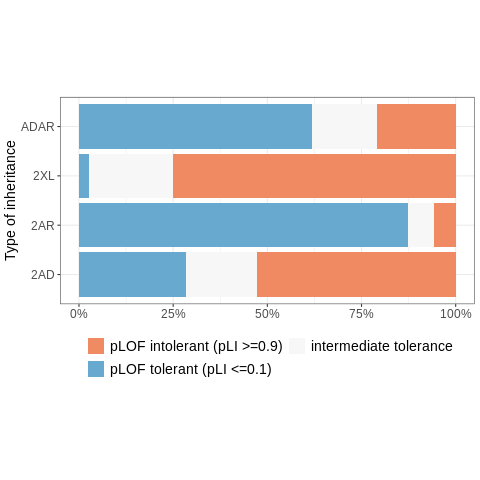

In [74]:
%%R

# stacked barchat
pli_bar <- ggplot(g2ph_pli_stat, aes(y=prop, x=Inh_class,
                               fill=factor(class, levels=c("pLOF intolerant (pLI >=0.9)",
                                                           "intermediate tolerance",
                                                           "pLOF tolerant (pLI <=0.1)", "NA")))) +
    geom_bar(position="stack", stat="identity")+
    theme_bw() + 
    theme(axis.text = element_text(size = 12), axis.title =  element_text(size=14), 
    legend.text=element_text(size=14)) + 
    xlab('Type of inheritance') +  
    ylab(NULL) + 
    scale_y_continuous(labels = percent_format())

pli_bar <- pli_bar + guides(fill=guide_legend(title=NULL, nrow=2, byrow=TRUE)) + theme(legend.position="bottom") + scale_fill_brewer(palette='RdBu')
pli_bar <- pli_bar + theme(aspect.ratio = 1/2)  + coord_flip()
pli_bar

### LOEUF

In [75]:
%%R

# select loeuf
gn_loeuf <- gnomad[ ,c(1,4)]
head(gn_loeuf)

   gene oe_lof_upper_bin
1 MED13                0
2 NIPBL                0
3  SMC3                0
4 CNOT1                0
5   RLF                0
6 PCF11                0


In [78]:
%%R

# genes with 2 associated diseases with estimated inheritance
g2ph_inh <- read.csv('./interm/Gene2Pheno_Inh.csv', sep='\t', header=TRUE)

g2ph_inh <- g2ph_inh %>% distinct()

print(dim(g2ph_inh))
print(head(g2ph_inh))

[1] 529   3
    GENE         Ensembl Inh_class
1  ABCA1 ENSG00000165029      ADAR
2 ABCA12 ENSG00000144452       2AR
3 ABCB11 ENSG00000073734       2AR
4   ACAN ENSG00000157766      ADAR
5   ACO2 ENSG00000100412       2AR
6  ACTG1 ENSG00000184009       2AD


In [79]:
%%R

g2ph_loeuf <- merge(x = g2ph_inh, y = gn_loeuf, by.x = "GENE", by.y='gene')
head(g2ph_loeuf)

    GENE         Ensembl Inh_class oe_lof_upper_bin
1  ABCA1 ENSG00000165029      ADAR                2
2 ABCA12 ENSG00000144452       2AR                2
3 ABCB11 ENSG00000073734       2AR                3
4   ACAN ENSG00000157766      ADAR                0
5   ACO2 ENSG00000100412       2AR                1
6  ACTG1 ENSG00000184009       2AD                4


In [80]:
%%R

# count
g2ph_loeuf_stat <- g2ph_loeuf%>%
  group_by(Inh_class, oe_lof_upper_bin) %>%
  summarize(count = n()) %>%
  mutate(prop = (count/sum(count)))

g2ph_loeuf_stat

`summarise()` has grouped output by 'Inh_class'. You can override using the
`.groups` argument.
# A tibble: 38 × 4
# Groups:   Inh_class [5]
   Inh_class oe_lof_upper_bin count   prop
   <fct>                <int> <int>  <dbl>
 1 2AD                      0    53 0.358 
 2 2AD                      1    38 0.257 
 3 2AD                      2    16 0.108 
 4 2AD                      3     8 0.0541
 5 2AD                      4     9 0.0608
 6 2AD                      5     5 0.0338
 7 2AD                      6     5 0.0338
 8 2AD                      7     5 0.0338
 9 2AD                      8     4 0.0270
10 2AD                      9     5 0.0338
# … with 28 more rows
# ℹ Use `print(n = ...)` to see more rows


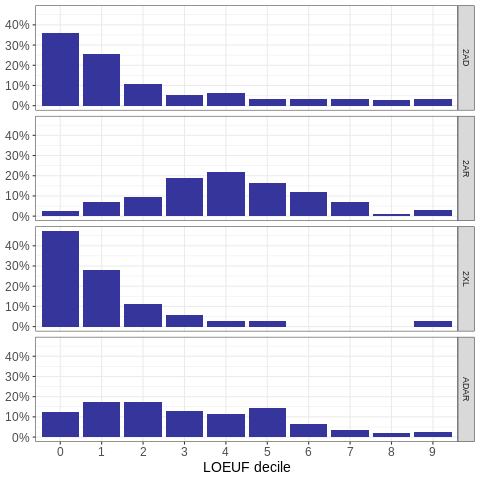

In [81]:
%%R
g2ph_loeuf_dec_pl <- ggplot(na.omit(g2ph_loeuf_stat), aes(x=as.factor(oe_lof_upper_bin), y=prop)) + geom_bar(stat='identity')+
 geom_bar(position="stack", stat="identity", fill='blue', alpha=0.4)+
    theme_bw() + 
    theme(axis.text = element_text(size = 12), axis.title =  element_text(size=14)) + 
    xlab('LOEUF decile') +  
    ylab(NULL) + 
    scale_y_continuous(labels = percent_format())


                      
g2ph_loeuf_dec_pl <- g2ph_loeuf_dec_pl + facet_wrap( ~ Inh_class, ncol=1, strip.position='right') + 
                theme(strip.text.x = element_text(size = 12, face = "bold"))

g2ph_loeuf_dec_pl

## Phenotypic similarity

In [83]:
! mkdir count_HPO

### Case: similarity of signs of 2 diseases associated with 1 gene

In [84]:
# select genes  with 2 associated syndromes

genes2pheno_to_mim = df_m[df_m['MIMs_per_Gene'] == 2]
genes2pheno_to_mim = genes2pheno_to_mim[['GENE', 'OMIM']].drop_duplicates()
genes2pheno_to_mim

,GENE,OMIM
47,DVL1,OMIM:616331
59,DVL1,OMIM:180700
69,ATAD3A,OMIM:618810
72,ATAD3A,OMIM:617183
99,PEX10,OMIM:614871
...,...,...
87572,OPN1MW,OMIM:303800
87950,RAB39B,OMIM:311510
87953,RAB39B,OMIM:300271
87957,SRY,OMIM:400044


In [85]:
# list of genes - MIM associations for genes with 2 diseases 

genes2pheno_to_mim.to_csv('./count_HPO/G2Ph_MIM.csv', sep='\t', index=False)

! sed -i 1d ./count_HPO/G2Ph_MIM.csv

In [86]:
# list of genes with 2 associated diseases

genes2pheno_to_mim['GENE'].drop_duplicates().to_csv('./count_HPO/G2Ph_genes.txt', sep='\t', index=False)

! sed -i 1d ./count_HPO/G2Ph_genes.txt

In [87]:
# rm header from MIM-HPO df

! cp ./data/phenotype.hpoa ./count_HPO/phenotype.hpoa
! sed -i '1,5d' ./count_HPO/phenotype.hpoa

In [88]:
# rm HPO terms related to inheritance
! sed -i '/HP:0000006/d' ./count_HPO/phenotype.hpoa
! sed -i '/HP:0000007/d' ./count_HPO/phenotype.hpoa
! sed -i '/HP:0010984/d' ./count_HPO/phenotype.hpoa
! sed -i '/HP:0010982/d' ./count_HPO/phenotype.hpoa
! sed -i '/HP:0001426/d' ./count_HPO/phenotype.hpoa
! sed -i '/HP:0001417/d' ./count_HPO/phenotype.hpoa
! sed -i '/HP:0001423/d' ./count_HPO/phenotype.hpoa
! sed -i '/HP:0001419/d' ./count_HPO/phenotype.hpoa
! sed -i '/HP:0001450/d' ./count_HPO/phenotype.hpoa
! sed -i '/HP:0001428/d' ./count_HPO/phenotype.hpoa
! sed -i '/HP:0001442/d' ./count_HPO/phenotype.hpoa
! sed -i '/HP:0034345/d' ./count_HPO/phenotype.hpoa
! wc -l ./count_HPO/phenotype.hpoa

244985 ./count_HPO/phenotype.hpoa


HPO term related to inheritance  
HP:0000006	Autosomal dominant inheritance  
HP:0000007	Autosomal recessive inheritance	 
HP:0034345	Mendelian inheritance
HP:0010984	Digenic inheritance  
HP:0010982	Polygenic inheritance  
HP:0001426	Multifactorial inheritance  
HP:0001417	X-linked inheritance  
HP:0001423	X-linked dominant inheritance  
HP:0001419	X-linked recessive inheritance  
HP:0001450	Y-linked inheritance  
HP:0001428	Somatic mutation  
HP:0001442	Somatic mosaicism  

In [89]:
# select columns
! cat ./count_HPO/phenotype.hpoa | cut -f1,4 | grep OMIM | sort > ./count_HPO/terms_to_mim.txt

In [90]:
# run script for similarity scores estimation

! bash ./script/g2ph_simscore.sh

/bin/bash: ./script/g2ph_simscore.sh: usr/bin/bash: неверный интерпретатор: Нет такого файла или каталога


In [9]:
%%R

# Analyze results 

simscore <- read.csv('./count_HPO/G2Ph_simscore.csv', sep=',', header=TRUE)
nrow(simscore)

[1] 525


In [10]:
%%R

# rm rows with less than 5 HPO terms per each disease
simscore_flt <-simscore[simscore$MIM1_terms >= 5, ]
simscore_flt <- simscore_flt[simscore_flt$MIM2_terms >= 5, ]

nrow(simscore_flt)

[1] 407


In [11]:
%%R

inh <- read.csv('./interm/Gene2Pheno_Inh.csv', sep='\t', header=TRUE)
head(inh)

    GENE         Ensembl Inh_class
1  ABCA1 ENSG00000165029      ADAR
2 ABCA12 ENSG00000144452       2AR
3 ABCB11 ENSG00000073734       2AR
4   ACAN ENSG00000157766      ADAR
5   ACO2 ENSG00000100412       2AR
6  ACTG1 ENSG00000184009       2AD


In [12]:
%%R

simscore_flt_inh <- merge(simscore_flt, inh, by='GENE', all.x=TRUE)

In [13]:
%%R
head(simscore_flt_inh)

    GENE        MIM1        MIM2    Jaccard HP_distance   Resnik MIM1_terms
1 ABCA12 OMIM:242500 OMIM:601277 0.07142857   0.3110863 2.339094          7
2 ABCB11 OMIM:601847 OMIM:605479 0.29411765   0.6393807 3.630803         15
3   ACAN OMIM:165800 OMIM:612813 0.08333333   0.3407970 1.827022         16
4   ACO2 OMIM:614559 OMIM:616289 0.03225806   0.2356639 1.106143         24
5  ACTG2 OMIM:155310 OMIM:619431 0.12000000   0.3833995 3.108070         18
6   ADA2 OMIM:182410 OMIM:615688 0.10256410   0.4063615 2.840506         24
  MIM2_terms         Ensembl Inh_class
1          8 ENSG00000144452       2AR
2          7 ENSG00000073734       2AR
3         23 ENSG00000157766      ADAR
4          8 ENSG00000100412       2AR
5         10 ENSG00000163017       2AD
6         62 ENSG00000093072       2AR


In [14]:
%%R
simscore_flt_inh <- simscore_flt_inh[ ,c(1,2,3,4,5,6,7,8,10)]

In [15]:
%%R

head(simscore_flt_inh)

    GENE        MIM1        MIM2    Jaccard HP_distance   Resnik MIM1_terms
1 ABCA12 OMIM:242500 OMIM:601277 0.07142857   0.3110863 2.339094          7
2 ABCB11 OMIM:601847 OMIM:605479 0.29411765   0.6393807 3.630803         15
3   ACAN OMIM:165800 OMIM:612813 0.08333333   0.3407970 1.827022         16
4   ACO2 OMIM:614559 OMIM:616289 0.03225806   0.2356639 1.106143         24
5  ACTG2 OMIM:155310 OMIM:619431 0.12000000   0.3833995 3.108070         18
6   ADA2 OMIM:182410 OMIM:615688 0.10256410   0.4063615 2.840506         24
  MIM2_terms Inh_class
1          8       2AR
2          7       2AR
3         23      ADAR
4          8       2AR
5         10       2AD
6         62       2AR


In [44]:
%%R 

simscore <- read.csv('./count_HPO/G2Ph_simscore.csv', sep=',', header=TRUE)
head(simscore)

     GENE        MIM1        MIM2    Jaccard HP_distance   Resnik MIM1_terms
1    DVL1 OMIM:616331 OMIM:180700 0.28409091   0.5879581 2.899841         43
2  ATAD3A OMIM:618810 OMIM:617183 0.15094340   0.4131614 1.718315         25
3   PEX10 OMIM:614871 OMIM:614870 0.02173913   0.2538733 1.442236         33
4  CEP104 OMIM:616781 OMIM:619988 0.12500000   0.3442758 1.138232          8
5   NPHP4 OMIM:606966 OMIM:606996 0.38461538   0.6264550 3.190275          9
6 PLEKHG5 OMIM:611067 OMIM:615376 0.14285714   0.4289116 2.219604         18
  MIM2_terms
1         70
2         36
3         14
4         10
5          9
6         14


In [45]:
%%R
sumgph2_50_sim <- merge(sumgph2_50, simscore, by='GENE', all.x=TRUE)
nrow(sumgph2_50_sim)

[1] 64


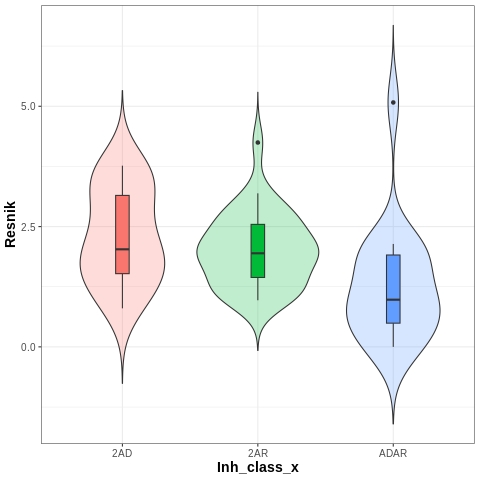

In [48]:
%%R

sumgph2_50_sim_pl <-ggplot(sumgph2_50_sim, aes(x=Inh_class_x, y=Resnik, fill=Inh_class_x)) + geom_violin(alpha=0.25, trim=FALSE) +
theme_bw() +
theme(axis.text = element_text(size = 10), axis.title =  element_text(size=14, face="bold"), legend.position="none")
sumgph2_50_sim_pl <- sumgph2_50_sim_pl + geom_boxplot(width=0.1)
sumgph2_50_sim_pl

### Control:  similarity scores for 2 random diseases

In [187]:
# select genes  with 2 associated syndromes

genes1pheno_to_mim = df_m[df_m['MIMs_per_Gene'] == 1]
genes1pheno_to_mim = genes1pheno_to_mim[['GENE', 'OMIM']].drop_duplicates()
genes1pheno_to_mim.shape

(2774, 2)

In [140]:
genes1pheno_to_mim.to_csv('./count_HPO/G1Ph_MIM.csv', sep='\t', index=False)

! sed -i 1d ./count_HPO/G1Ph_MIM.csv

In [ ]:
! bash ./script/random_simscore.sh 

In [6]:
%%R

# Analyze results 

simscore_random <- read.csv('./count_HPO/G1Ph_simscore.csv', sep=',',header=TRUE)
print(nrow(simscore_random))
print(head(simscore_random))

[1] 529
         MIM1        MIM2    Jaccard HP_distance       Resnik MIM1_terms
1 OMIM:617062 OMIM:300958 0.12280702   0.4052614 1.5984000290         33
2 OMIM:619705 OMIM:308700 0.02222222   0.1528284 0.2967374100         20
3 OMIM:614203 OMIM:610031 0.00000000   0.1693935 0.8746089896          8
4 OMIM:119800 OMIM:208230 0.00000000   0.1502855 1.3041275012         18
5 OMIM:616357 OMIM:617020 0.00000000   0.1058586 0.0003397914          2
6 OMIM:604571 OMIM:266500 0.00000000   0.1444020 0.8905499934          9
  MIM2_terms
1         31
2         26
3         19
4         23
5         10
6         23


In [7]:
%%R

simscore_r_flt <-simscore_random[simscore_random $MIM1_terms >= 5, ]
simscore_r_flt <- simscore_r_flt[simscore_r_flt$MIM2_terms >= 5, ]
nrow(simscore_r_flt)

[1] 424


### Phenotypic similarity. Plots

In [16]:
%%R

simscore_r_flt['Group'] <- 'Random disease pairs'
simscore_flt_inh['Group'] <- '2 diseases linked to 1 gene '

In [17]:
%%R
simscore_r_flt['GENE'] <- 'NA'
simscore_r_flt['Inh_class'] <- 'NA'

In [18]:
%%R
head(simscore_r_flt)

         MIM1        MIM2    Jaccard HP_distance    Resnik MIM1_terms
1 OMIM:617062 OMIM:300958 0.12280702   0.4052614 1.5984000         33
2 OMIM:619705 OMIM:308700 0.02222222   0.1528284 0.2967374         20
3 OMIM:614203 OMIM:610031 0.00000000   0.1693935 0.8746090          8
4 OMIM:119800 OMIM:208230 0.00000000   0.1502855 1.3041275         18
6 OMIM:604571 OMIM:266500 0.00000000   0.1444020 0.8905500          9
7 OMIM:300971 OMIM:259720 0.00000000   0.1354453 0.6883828         10
  MIM2_terms                Group GENE Inh_class
1         31 Random disease pairs   NA        NA
2         26 Random disease pairs   NA        NA
3         19 Random disease pairs   NA        NA
4         23 Random disease pairs   NA        NA
6         23 Random disease pairs   NA        NA
7         55 Random disease pairs   NA        NA


In [19]:
%%R

sim_merge <- rbind(simscore_flt_inh, simscore_r_flt)
head(sim_merge)

    GENE        MIM1        MIM2    Jaccard HP_distance   Resnik MIM1_terms
1 ABCA12 OMIM:242500 OMIM:601277 0.07142857   0.3110863 2.339094          7
2 ABCB11 OMIM:601847 OMIM:605479 0.29411765   0.6393807 3.630803         15
3   ACAN OMIM:165800 OMIM:612813 0.08333333   0.3407970 1.827022         16
4   ACO2 OMIM:614559 OMIM:616289 0.03225806   0.2356639 1.106143         24
5  ACTG2 OMIM:155310 OMIM:619431 0.12000000   0.3833995 3.108070         18
6   ADA2 OMIM:182410 OMIM:615688 0.10256410   0.4063615 2.840506         24
  MIM2_terms Inh_class                        Group
1          8       2AR 2 diseases linked to 1 gene 
2          7       2AR 2 diseases linked to 1 gene 
3         23      ADAR 2 diseases linked to 1 gene 
4          8       2AR 2 diseases linked to 1 gene 
5         10       2AD 2 diseases linked to 1 gene 
6         62       2AR 2 diseases linked to 1 gene 


In [46]:
%%R

sim_merge <- rbind(simscore_flt[,c(2:9)], simscore_r_flt)
tail(sim_merge)

            MIM1        MIM2    Jaccard HP_distance    Resnik MIM1_terms
523  OMIM:266265 OMIM:615862 0.00000000   0.1571136 0.3260135         28
5241 OMIM:245600 OMIM:259100 0.01904762   0.2497546 1.9980896         81
5251 OMIM:604805 OMIM:213980 0.00000000   0.1603693 1.1313190         14
526  OMIM:615705 OMIM:249500 0.03703704   0.3209064 1.6422889         21
528  OMIM:615859 OMIM:617526 0.00000000   0.1154748 0.6643927         18
529  OMIM:618367 OMIM:615220 0.08695652   0.2986060 1.2293744         13
     MIM2_terms  Group
523          11 Random
5241         26 Random
5251         82 Random
526           7 Random
528           6 Random
529          12 Random


In [20]:
%%R 

write.csv(sim_merge, './G2Ph_simscore_for_plot.csv', quote=FALSE)

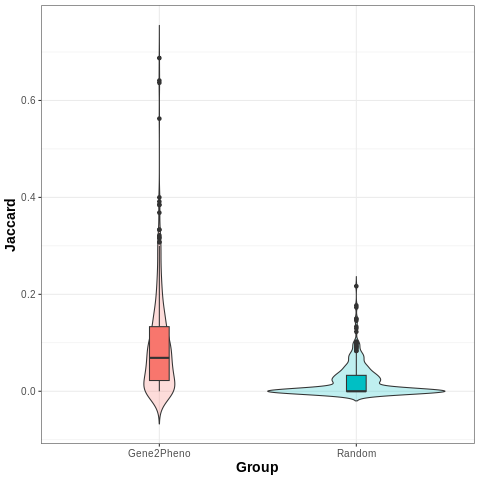

In [216]:
%%R

sim_jacc <-ggplot(sim_merge, aes(x=Group, y=Jaccard, fill=Group)) + geom_violin(alpha=0.25, trim=FALSE) +
theme_bw() +
theme(axis.text = element_text(size = 10), axis.title =  element_text(size=14, face="bold"), legend.position="none")
sim_jacc <- sim_jacc + geom_boxplot(width=0.1)
sim_jacc

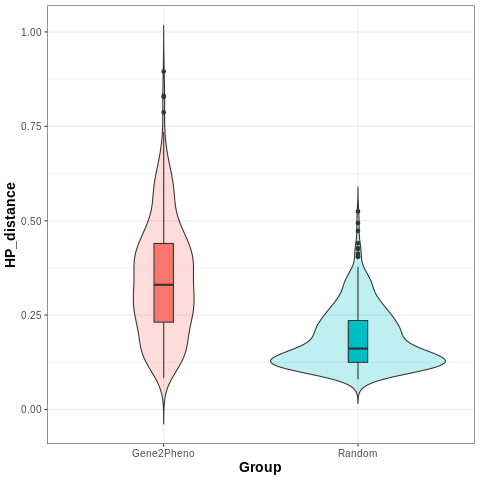

In [215]:
%%R

sim_dist <-ggplot(sim_merge, aes(x = Group, y=HP_distance,fill=Group)) + geom_violin(alpha=0.25, trim=FALSE) + theme_bw() +
theme(axis.text = element_text(size = 10), axis.title =  element_text(size=14, face="bold"), legend.position="none")

sim_dist <- sim_dist + geom_boxplot(width=0.1) 
sim_dist

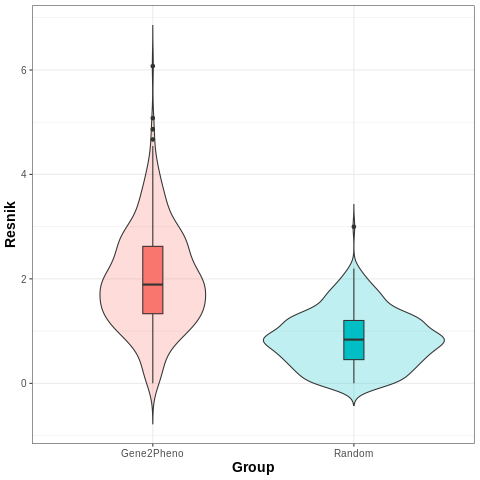

In [218]:
%%R

sim_res <-ggplot(sim_merge, aes(x = Group, y=Resnik, fill=Group)) + geom_violin(alpha=0.25, trim=FALSE) +
theme_bw() + theme(axis.text = element_text(size = 10), axis.title =  element_text(size=14, face="bold"),legend.position="none")
sim_res <- sim_res + geom_boxplot(width=0.1)
sim_res

##  7. Variants analysis

In [95]:
! mkdir ./VarCount

In [92]:
# select genes with 2 diseases

df_g2ph = df_m[df_m['MIMs_per_Gene'] == 2]
df_2ph = df_g2ph.groupby(['GENE', 'Ensembl','OMIM']).size().reset_index(name = 'Variants_per_MIM')
df_2ph

,GENE,Ensembl,OMIM,Variants_per_MIM
0,ABCA1,ENSG00000165029,OMIM:205400,13
1,ABCA1,ENSG00000165029,OMIM:604091,5
2,ABCA12,ENSG00000144452,OMIM:242500,11
3,ABCA12,ENSG00000144452,OMIM:601277,7
4,ABCB11,ENSG00000073734,OMIM:601847,36
...,...,...,...,...
1053,ZIC3,ENSG00000156925,OMIM:314390,2
1054,ZMPSTE24,ENSG00000084073,OMIM:275210,10
1055,ZMPSTE24,ENSG00000084073,OMIM:608612,8
1056,ZSWIM6,ENSG00000130449,OMIM:603671,1


In [93]:
df_g2ph['GENE'].drop_duplicates().shape

(530,)

In [96]:
# list of genes with 2 associated phenotypes

df_g2ph_list = df_g2ph['Ensembl'].drop_duplicates()
df_g2ph_list.to_csv('./VarCount/G2Ph_ensembl_list.csv', sep='\t', index=False)

! sed -i 1d ./VarCount/G2Ph_ensembl_list.csv

## Statistical analysis of  within-gene distribution and type of variants 

### Collect associated with each disease variants

##### collect all variants 

In [141]:
dis1 = df_2ph.drop_duplicates(subset = ['Ensembl'], keep = 'first')
dis1

,GENE,Ensembl,OMIM,Variants_per_MIM
0,ABCA1,ENSG00000165029,OMIM:205400,13
2,ABCA12,ENSG00000144452,OMIM:242500,11
4,ABCB11,ENSG00000073734,OMIM:601847,36
6,ACAN,ENSG00000157766,OMIM:165800,7
8,ACO2,ENSG00000100412,OMIM:614559,14
...,...,...,...,...
1048,ZAP70,ENSG00000115085,OMIM:269840,4
1050,ZC4H2,ENSG00000126970,OMIM:301041,9
1052,ZIC3,ENSG00000156925,OMIM:306955,22
1054,ZMPSTE24,ENSG00000084073,OMIM:275210,10


In [98]:
dis1[['Ensembl', 'OMIM']].to_csv('./VarCount/G2Ph_dis1.csv', sep='\t', index=False)

In [99]:
# save variants associated with dis1 

df_dis1 = df_g2ph.merge(dis1, how = 'inner')
print(df_dis1.head(2))
print(df_dis1.shape)

  CHROM      POS       ID                                                REF  \
0  chr1  1338053   208049                                                 TG   
1  chr1  1516567  1077177  CACACCTGGCTAATTTTTATATTTTTAGTAGAGTCGGGGTTTCACC...   

  ALT  QUAL FILTER    GENE      CLNSIG  \
0   T -10.0   PASS    DVL1  Pathogenic   
1   C -10.0   PASS  ATAD3A  Pathogenic   

                                             MC         OMIM Inheritance  \
0                            frameshift_variant  OMIM:180700          AD   
1  splice_acceptor_variant,splice_donor_variant  OMIM:617183        ADAR   

           Ensembl  MIMs_per_Gene  Variants_per_MIM  
0  ENSG00000107404              2                 1  
1  ENSG00000197785              2                 3  
(11694, 15)


In [100]:
df_dis1[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('./VarCount/G2Pheno_dis1_all_variants.vcf', sep='\t', index=False)

In [101]:
! cat ./vcf_header.txt ./VarCount/G2Pheno_dis1_all_variants.vcf >./VarCount/G2Ph_dis1_all_variants.vcf
! rm ./VarCount/G2Pheno_dis1_all_variants.vcf
! sed -i 's/CHROM/#CHROM/g' ./VarCount/G2Ph_dis1_all_variants.vcf

In [102]:
# extract 2nd disease

dis2 = df_2ph.drop_duplicates(subset = ['Ensembl'], keep = 'last')
dis2

,GENE,Ensembl,OMIM,Variants_per_MIM
1,ABCA1,ENSG00000165029,OMIM:604091,5
3,ABCA12,ENSG00000144452,OMIM:601277,7
5,ABCB11,ENSG00000073734,OMIM:605479,11
7,ACAN,ENSG00000157766,OMIM:612813,2
9,ACO2,ENSG00000100412,OMIM:616289,4
...,...,...,...,...
1049,ZAP70,ENSG00000115085,OMIM:617006,1
1051,ZC4H2,ENSG00000126970,OMIM:314580,15
1053,ZIC3,ENSG00000156925,OMIM:314390,2
1055,ZMPSTE24,ENSG00000084073,OMIM:608612,8


In [103]:
dis2[['Ensembl', 'OMIM']].to_csv('./VarCount/G2Ph_dis2.csv', sep='\t', index=False)

In [104]:
# save variants associated with 2nd disease

df_dis2 = df_g2ph.merge(dis2, how = 'inner')

print(df_dis2.head(2))
print(df_dis2.shape)

  CHROM      POS      ID REF ALT  QUAL FILTER  GENE      CLNSIG  \
0  chr1  1338000  208047  CT   C -10.0   PASS  DVL1  Pathogenic   
1  chr1  1338023  981467  CG   C -10.0   PASS  DVL1  Pathogenic   

                   MC         OMIM Inheritance          Ensembl  \
0  frameshift_variant  OMIM:616331          AD  ENSG00000107404   
1  frameshift_variant  OMIM:616331          AD  ENSG00000107404   

   MIMs_per_Gene  Variants_per_MIM  
0              2                12  
1              2                12  
(7411, 15)


In [105]:
df_dis2[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('./VarCount/G2Pheno_dis2_all_variants.vcf', sep='\t', index=False)

In [106]:
! cat ./vcf_header.txt ./VarCount/G2Pheno_dis2_all_variants.vcf >./VarCount/G2Ph_dis2_all_variants.vcf
! rm ./VarCount/G2Pheno_dis2_all_variants.vcf
! sed -i 's/CHROM/#CHROM/g' ./VarCount/G2Ph_dis2_all_variants.vcf

##### collect variants without pleiotropic effect

In [142]:
# rm variants that have association with both diseases

snps_dis1 = df_dis1[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']]
snps_dis2 = df_dis2[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']]
snps_d1d2 = pd.merge(snps_dis1, snps_dis2, how='outer', indicator=True)

print(snps_dis1.shape)
print(snps_dis2.shape)
print(snps_d1d2.shape)
print(snps_d1d2[snps_d1d2['_merge'] == 'both'].shape)

(11694, 7)
(7411, 7)
(15438, 8)
(3667, 8)


In [143]:
snps_d1d2 = snps_d1d2[snps_d1d2['_merge'] != 'both']
snps_d1d2.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,_merge
1,chr1,1516567,1077177,CACACCTGGCTAATTTTTATATTTTTAGTAGAGTCGGGGTTTCACC...,C,-10.0,PASS,left_only
2,chr1,1527718,1685550,A,G,-10.0,PASS,left_only
3,chr1,1529299,225696,C,T,-10.0,PASS,left_only
4,chr1,2406569,1686018,C,G,-10.0,PASS,left_only
19,chr1,3816372,221277,T,C,-10.0,PASS,left_only


In [144]:
snps_d1_un = snps_d1d2[snps_d1d2['_merge'] == 'left_only']
snps_d1_un.shape

(8027, 8)

In [111]:
snps_d1_un[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('./VarCount/G2Pheno_dis1_uniq_variants.vcf', sep='\t', index=False)

In [112]:
! cat ./vcf_header.txt ./VarCount/G2Pheno_dis1_uniq_variants.vcf >./VarCount/G2Ph_dis1_uniq.vcf
! rm ./VarCount/G2Pheno_dis1_uniq_variants.vcf
! sed -i 's/CHROM/#CHROM/g' ./VarCount/G2Ph_dis1_uniq.vcf

In [113]:
snps_d2_un = snps_d1d2[snps_d1d2['_merge'] == 'right_only']
snps_d2_un.shape

(3744, 8)

In [114]:

snps_d2_un[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('./VarCount/G2Pheno_dis2_uniq_variants.vcf', sep='\t', index=False)

In [115]:
! cat ./vcf_header.txt ./VarCount/G2Pheno_dis2_uniq_variants.vcf >./VarCount/G2Ph_dis2_uniq.vcf
! rm ./VarCount/G2Pheno_dis2_uniq_variants.vcf
! sed -i 's/CHROM/#CHROM/g' ./VarCount/G2Ph_dis2_uniq.vcf

##### collect all missense and pLOF variants

In [154]:
df_dis1

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,GENE,CLNSIG,MC,OMIM,Inheritance,Ensembl,MIMs_per_Gene,Variants_per_MIM
0,chr1,1338053,208049,TG,T,-10.0,PASS,DVL1,Pathogenic,frameshift_variant,OMIM:180700,AD,ENSG00000107404,2,1
1,chr1,1516567,1077177,CACACCTGGCTAATTTTTATATTTTTAGTAGAGTCGGGGTTTCACC...,C,-10.0,PASS,ATAD3A,Pathogenic,"splice_acceptor_variant,splice_donor_variant",OMIM:617183,ADAR,ENSG00000197785,2,3
2,chr1,1527718,1685550,A,G,-10.0,PASS,ATAD3A,Pathogenic/Likely_pathogenic,missense_variant,OMIM:617183,ADAR,ENSG00000197785,2,3
3,chr1,1529299,225696,C,T,-10.0,PASS,ATAD3A,Pathogenic/Likely_pathogenic,missense_variant,OMIM:617183,ADAR,ENSG00000197785,2,3
4,chr1,2406569,1686018,C,G,-10.0,PASS,PEX10,Pathogenic,"missense_variant,non-coding_transcript_variant",OMIM:614870,AR,ENSG00000157911,2,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11689,chrY,2787435,664404,G,A,-10.0,PASS,SRY,Pathogenic,nonsense,OMIM:400044,YL,ENSG00000184895,2,27
11690,chrY,2787515,492908,C,A,-10.0,PASS,SRY,Pathogenic,missense_variant,OMIM:400044,YL,ENSG00000184895,2,27
11691,chrY,2787551,9754,C,T,-10.0,PASS,SRY,Pathogenic,missense_variant,OMIM:400044,YL,ENSG00000184895,2,27
11692,chrY,2787592,9751,A,T,-10.0,PASS,SRY,Pathogenic,nonsense,OMIM:400044,YL,ENSG00000184895,2,27


In [155]:
# subset missense variants dis1

df_dis1_miss = df_dis1[df_dis1['MC'].str.contains('missense', na=False, case=False, regex=False)]

In [156]:
df_dis1_miss[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('./VarCount/Gene2Pheno_dis1_miss.vcf', sep='\t', index=False)

In [157]:
! cat ./vcf_header.txt ./VarCount/Gene2Pheno_dis1_miss.vcf > ./VarCount/G2Ph_dis1_miss.vcf
! rm ./VarCount/Gene2Pheno_dis1_miss.vcf 
! sed -i 's/CHROM/#CHROM/g' ./VarCount/G2Ph_dis1_miss.vcf

In [158]:
# subset pLOF variants dis2
 
df_dis1_plof = df_dis1[~df_dis1['MC'].str.contains('missense', na=False, case=False, regex=False)]
df_dis1_plof = df_dis1_plof[df_dis1_plof['MC'].str.contains('frameshift') | df_dis1_plof['MC'].str.contains('stop_gained') | df_dis1_plof['MC'].str.contains('splice_donor') | df_dis1_plof['MC'].str.contains('splice_acceptor')]

In [159]:
df_dis1_plof[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('./VarCount/Gene2Pheno_dis1_plof.vcf', sep='\t', index=False)

In [160]:
! cat ./vcf_header.txt ./VarCount/Gene2Pheno_dis1_plof.vcf > ./VarCount/G2Ph_dis1_plof.vcf
! rm ./VarCount/Gene2Pheno_dis1_plof.vcf 
! sed -i 's/CHROM/#CHROM/g' ./VarCount/G2Ph_dis1_plof.vcf

In [161]:
# subset missense variants dis2

df_dis2_miss = df_dis2[df_dis2['MC'].str.contains('missense', na=False, case=False, regex=False)]

In [162]:
df_dis2_miss.shape

(2234, 15)

In [163]:
df_dis2_miss[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('./VarCount/Gene2Pheno_dis2_miss.vcf', sep='\t', index=False)

In [164]:
! cat ./vcf_header.txt ./VarCount/Gene2Pheno_dis2_miss.vcf > ./VarCount/G2Ph_dis2_miss.vcf
! rm ./VarCount/Gene2Pheno_dis2_miss.vcf 
! sed -i 's/CHROM/#CHROM/g' ./VarCount/G2Ph_dis2_miss.vcf

In [165]:
# subset pLOF variants dis2

df_dis2_plof = df_dis2[~df_dis2['MC'].str.contains('missense',na=False, case=False, regex=False)]
df_dis2_plof = df_dis2_plof[df_dis2_plof['MC'].str.contains('frameshift', na=False, case=False, regex=False) | df_dis2_plof['MC'].str.contains('stop_gained', na=False, case=False, regex=False) | df_dis2_plof['MC'].str.contains('splice_donor', na=False, case=False, regex=False) | df_dis2_plof['MC'].str.contains('splice_acceptor', na=False, case=False, regex=False)]

In [166]:
df_dis2_plof[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('./VarCount/Gene2Pheno_dis2_plof.vcf', sep='\t', index=False)

In [167]:
! cat ./vcf_header.txt ./VarCount/Gene2Pheno_dis2_plof.vcf > ./VarCount/G2Ph_dis2_plof.vcf
! rm ./VarCount/Gene2Pheno_dis2_plof.vcf 
! sed -i 's/CHROM/#CHROM/g' ./VarCount/G2Ph_dis2_plof.vcf

##### collect missense and pLOF variants without pleiotropic effect 

In [168]:
# rm missense variants that have association with both diseases

snps_dis1_m = df_dis1_miss[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']]
snps_dis2_m = df_dis2_miss[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']]
snps_d1d2_m = pd.merge(snps_dis1_m, snps_dis2_m, how='outer', indicator=True)

print(snps_d1d2_m.shape)
print(snps_d1d2_m[snps_d1d2_m['_merge'] == 'both'].shape)

(4264, 8)
(906, 8)


In [169]:
snps_d1d2_m = snps_d1d2_m[snps_d1d2_m['_merge'] != 'both']
snps_d1d2_m.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,_merge
0,chr1,1527718,1685550,A,G,-10.0,PASS,left_only
1,chr1,1529299,225696,C,T,-10.0,PASS,left_only
2,chr1,2406569,1686018,C,G,-10.0,PASS,left_only
5,chr1,5874946,3402,A,G,-10.0,PASS,left_only
6,chr8,60816389,2033,C,T,-10.0,PASS,left_only


In [170]:
snps_d1_m_un = snps_d1d2_m[snps_d1d2_m['_merge'] == 'left_only']
snps_d1_m_un.shape

(2030, 8)

In [172]:
snps_d1_m_un[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('./VarCount/Gene2Pheno_dis1_uniq_miss.vcf', sep='\t', index=False)

In [173]:
! cat ./vcf_header.txt ./VarCount/Gene2Pheno_dis1_uniq_miss.vcf >./VarCount/G2Ph_dis1_uniq_miss.vcf
! rm ./VarCount/Gene2Pheno_dis1_uniq_miss.vcf
! sed -i 's/CHROM/#CHROM/g' ./VarCount/G2Ph_dis1_uniq_miss.vcf

In [174]:
snps_d2_m_un = snps_d1d2_m[snps_d1d2_m['_merge'] == 'right_only']
snps_d2_m_un.shape

(1328, 8)

In [175]:

snps_d2_m_un[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('./VarCount/Gene2Pheno_dis2_uniq_miss.vcf', sep='\t', index=False)

In [176]:
! cat ./vcf_header.txt ./VarCount/Gene2Pheno_dis2_uniq_miss.vcf >./VarCount/G2Ph_dis2_uniq_miss.vcf
! rm ./VarCount/Gene2Pheno_dis2_uniq_miss.vcf
! sed -i 's/CHROM/#CHROM/g' ./VarCount/G2Ph_dis2_uniq_miss.vcf

In [177]:
# rm plof variants that have association with both diseases

snps_dis1_p = df_dis1_plof[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']]
snps_dis2_p = df_dis2_plof[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']]
snps_d1d2_p = pd.merge(snps_dis1_p, snps_dis2_p, how='outer', indicator=True)

print(snps_d1d2_p.shape)
print(snps_d1d2_p[snps_d1d2_p['_merge'] == 'both'].shape)

(6491, 8)
(1520, 8)


In [178]:
snps_d1d2_p = snps_d1d2_p[snps_d1d2_p['_merge'] != 'both']
snps_d1d2_p.head()

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,_merge
1,chr1,1516567,1077177,CACACCTGGCTAATTTTTATATTTTTAGTAGAGTCGGGGTTTCACC...,C,-10.0,PASS,left_only
10,chr1,3816372,221277,T,C,-10.0,PASS,left_only
11,chr1,3835081,221275,G,GA,-10.0,PASS,left_only
12,chr1,3837319,542193,AGGGAGTAACG,A,-10.0,PASS,left_only
13,chr1,3839606,221274,A,G,-10.0,PASS,left_only


In [179]:
snps_d1_p_un = snps_d1d2_p[snps_d1d2_p['_merge'] == 'left_only']
snps_d1_p_un.shape

(3551, 8)

In [180]:
snps_d1_p_un[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('./VarCount/Gene2Pheno_dis1_uniq_plof.vcf', sep='\t', index=False)

In [181]:
! cat ./vcf_header.txt ./VarCount/Gene2Pheno_dis1_uniq_plof.vcf >./VarCount/G2Ph_dis1_uniq_plof.vcf
! rm ./VarCount/Gene2Pheno_dis1_uniq_plof.vcf
! sed -i 's/CHROM/#CHROM/g' ./VarCount/G2Ph_dis1_uniq_plof.vcf

In [182]:
snps_d2_p_un = snps_d1d2_p[snps_d1d2_p['_merge'] == 'right_only']
snps_d2_p_un.shape

(1420, 8)

In [183]:

snps_d2_p_un[['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER']].to_csv('./VarCount/Gene2Pheno_dis2_uniq_plof.vcf', sep='\t', index=False)

In [184]:
! cat ./vcf_header.txt ./VarCount/Gene2Pheno_dis2_uniq_plof.vcf >./VarCount/G2Ph_dis2_uniq_plof.vcf
! rm ./VarCount/Gene2Pheno_dis2_uniq_plof.vcf
! sed -i 's/CHROM/#CHROM/g' ./VarCount/G2Ph_dis2_uniq_plof.vcf

### Analysis of variants loclization and variant type

#### Data for the analysis:

###### - List of canonical transcripts (source: Ensembl BioMart). PathTo: ./data/canonical_transcripts.txt

###### - Gencode annotation

###### - Selected genes list (Ensembl IDs). PathTo: ./VarCount/G2Ph_ensembl_list.csv

###### - Selected variants annotated to diseases (.vcf)

### Variant localization

In [ ]:
# Split canonical transcript on 5 equal intervals and collect all variants asscoiated with each disease connected to the gene
! bash ./script/g2ph_countvariants_b5all.sh

In [ ]:
# Split canonical transcript on 2 equal intervals and collect all variants asscoiated with each disease connected to the gene
! bash ./script/g2ph_countvariants_b2all.sh

In [ ]:
# Split canonical transcript on 5 equal intervals and collect variants w/o pleiotropic effect for each disease connected to the gene
! bash ./script/g2ph_countvariants_b5u.sh

In [ ]:
# Split canonical transcript on 2 equal intervals and collect variants w/o pleiotropic effect for each disease connected to the gene
! bash ./script/g2ph_countvariants_b2u.sh

### Variant type

In [ ]:
# Collect all missense variants and all pLOF variants 
! bash ./script/g2ph_countvariants_mp_all.sh

In [ ]:
# Collect missense variants and all pLOF variants  w/o pleiotropic effect
! bash ./script/g2ph_countvariants_mp_u.sh

####  Fisher's exact test

In [8]:
%%R

## Q-Q plot ##
# source:   https://slowkow.com/notes/ggplot2-qqplot
gg_qqplot <- function(ps, ci = 0.95) {
  n  <- length(ps)   # number of observations
  df1 <- data.frame(
    observed = -log10(sort(ps)),
    expected = -log10(ppoints(n)),   # prediction based on number of observations
    clower   = -log10(qbeta(p = (1 - ci) / 2, shape1 = 1:n, shape2 = n:1)),
    cupper   = -log10(qbeta(p = (1 + ci) / 2, shape1 = 1:n, shape2 = n:1))
  )
  log10Pe <- expression(paste("Expected -log"[10], plain(P)))
  log10Po <- expression(paste("Observed -log"[10], plain(P)))
  ggplot(df1) +
    geom_ribbon(
      mapping = aes(x = expected, ymin = clower, ymax = cupper),
      alpha = 0.1
    ) +
    geom_point(aes(expected, observed), shape = 1, size = 3) +
    geom_abline(intercept = 0, slope = 1, alpha = 0.5) +
    xlab(log10Pe) +
    ylab(log10Po)
}

In [9]:
%%R

# results illustration
plot_fisher <- function(fisher_res){
    
    #   Q-Q plot
    qqplot <- gg_qqplot(as.numeric(fisher_res$p_value)) +
    theme_bw(base_size = 14) +theme(axis.ticks = element_line(size = 0.5),panel.grid = element_blank())
    
    print(qqplot)
    
    #   Barplot
    pval_count <- fisher_res%>% 
      group_by(pvalue_interval) %>%
      summarize(count = n()) %>%
      mutate(prop = (count/sum(count)))
    
    pval_barpl <- ggplot(pval_count, aes(x=factor(pvalue_interval), y=prop)) + geom_bar(stat='identity', fill='blue', alpha=0.4)+ theme_bw() + xlab(NULL) + theme(axis.text = element_text(size = 12), axis.title =  element_text(size=14), 
    legend.text=element_text(size=10)) +  ylab('p-value distribution') +  scale_y_continuous(labels = percent_format())
    
    print(pval_barpl)    
}

##### Parse results of splitting CDS on 5 intervals

In [10]:
%%R

fisher_b5 <- function(bins5){
    
    colnames(bins5) <- c('Ensembl', 'd1_1', 'd1_2', 'd1_3', 'd1_4', 'd1_5', 
                     'd2_1','d2_2','d2_3','d2_4','d2_5')
    bins5$Ensembl <- as.character(bins5$Ensembl)
    
    # filter results - rm genes with less than 5 associated variants per disease
    bins5 <- bins5 %>% filter((rowSums(bins5[ , c(2:6)], na.rm=TRUE) >=5) & (rowSums(bins5[ , c(7:11)], na.rm=TRUE) >=5))
    
    fisher_res <- data.frame(matrix(ncol=2, nrow=0))   
    colnames(fisher_res) <- c('Ensembl', 'p_value')
    
    # Fiher's exact test
    for (r in 1:nrow(bins5)){   
        matr <- matrix(c(as.numeric(bins5[r,2:ncol(bins5)])),ncol=(ncol(bins5)-1)/2, byrow=T)
        if (all(matr == 0)){   # exclude genes with no variants
            next
        }
        test <- fisher.test(matr,workspace = 2e8)
        fisher_res[nrow(fisher_res) + 1,] <- c(bins5[r,1], as.numeric(test$p.value))   # add gene_id and p-value
    }
    df <- merge(fisher_res, bins5, by='Ensembl', all.x = TRUE)
    
    # adjust p-value
    df$p_value <- as.numeric(df$p_value)   
    df$p_adj <-p.adjust(df$p_value, method = "fdr")
    df$log_pvalue <- -log10(as.numeric(df$p_value)) 
    df$log_padj <- -log10(as.numeric(df$p_adj)) 
    
 
    df <- df %>%
     mutate(pvalue_interval = case_when(
     p_value < 0.1 ~ "0-0.1", 
     p_value >= 0.1 & p_value < 0.2 ~ "0.1-0.2",
     p_value >= 0.2 & p_value < 0.3 ~ "0.2-0.3",
     p_value >= 0.3 & p_value < 0.4 ~ "0.3-0.4",
     p_value >= 0.4 & p_value < 0.5 ~ "0.4-0.5",
     p_value >= 0.5 & p_value < 0.6 ~ "0.5-0.6",
     p_value >= 0.6 & p_value < 0.7 ~ "0.6-0.7",
     p_value >= 0.7 & p_value < 0.8 ~ "0.7-0.8",
     p_value >= 0.8 & p_value < 0.9 ~ "0.8-0.9",
     p_value >= 0.9 ~ "0.9-1"))
    
    df$pvalue_interval <- as.factor(df$pvalue_interval)
    
    df <- df[ ,c(1,16,2,14,13,15,3,4,5,6,7,8,9,10,11,12)]
   
}

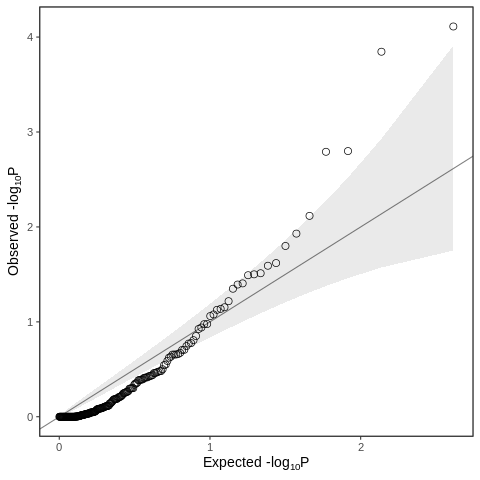

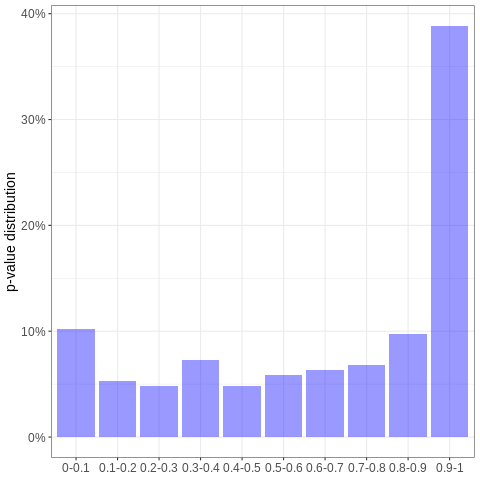

In [278]:
%%R

# Load data: all genes associated with 2 diseases, all variants
bins5_all <- read.csv('./VarCount/G2Ph_bins5_all.csv', sep=',', header=T)

# Fisher's exact test
bins5_all_FT <- fisher_b5(bins5_all)

# Plot results
plot_fisher(bins5_all_FT)

# Save results
write.csv(bins5_all_FT,"./VarCount/G2Ph_bins5_all_FT.csv", row.names = FALSE, quote = F)



##### Parse results of splitting CDS on 5 intervals

In [11]:
%%R

fisher_b2 <- function(bins2){
    
    colnames(bins2) <- c('Ensembl', 'd1_1', 'd1_2', 'd2_1', 'd2_2')
    bins2$Ensembl <- as.character(bins2$Ensembl)
    
    # filter results - rm genes with less than 5 associated variants per disease
    bins2 <- bins2 %>% filter((rowSums(bins2[ , c(2,3)], na.rm=TRUE) >=5) & (rowSums(bins2[ , c(4,5)], na.rm=TRUE) >=5))
    
    
    fisher_res <- data.frame(matrix(ncol=2, nrow=0))   
    colnames(fisher_res) <- c('Ensembl', 'p_value')
    
    # Fisher's exact test
    for (r in 1:nrow(bins2)){   
        matr <- matrix(c(as.numeric(bins2[r,2:ncol(bins2)])),ncol=(ncol(bins2)-1)/2, byrow=T)
        if (all(matr == 0)){   # exclude genes with no variants
            next
        }
        test <- fisher.test(matr,workspace = 2e8)
        fisher_res[nrow(fisher_res) + 1,] <- c(bins2[r,1], as.numeric(test$p.value))   # add gene_id and p-value
    }
    df <- merge(fisher_res, bins2, by='Ensembl', all.x = TRUE)
    
    # adjust p-value
    df$p_value <- as.numeric(df$p_value)   
    df$p_adj <-p.adjust(df$p_value, method = "fdr")
    df$log_pvalue <- -log10(as.numeric(df$p_value)) 
    df$log_padj <- -log10(as.numeric(df$p_adj)) 
    
 
    df <- df %>%
     mutate(pvalue_interval = case_when(
     p_value < 0.1 ~ "0-0.1", 
     p_value >= 0.1 & p_value < 0.2 ~ "0.1-0.2",
     p_value >= 0.2 & p_value < 0.3 ~ "0.2-0.3",
     p_value >= 0.3 & p_value < 0.4 ~ "0.3-0.4",
     p_value >= 0.4 & p_value < 0.5 ~ "0.4-0.5",
     p_value >= 0.5 & p_value < 0.6 ~ "0.5-0.6",
     p_value >= 0.6 & p_value < 0.7 ~ "0.6-0.7",
     p_value >= 0.7 & p_value < 0.8 ~ "0.7-0.8",
     p_value >= 0.8 & p_value < 0.9 ~ "0.8-0.9",
     p_value >= 0.9 ~ "0.9-1"))
    
    df$pvalue_interval <- as.factor(df$pvalue_interval)
    
    df <- df[ ,c(1,10,2,7,8,9,3,4,5,6)]
   
}

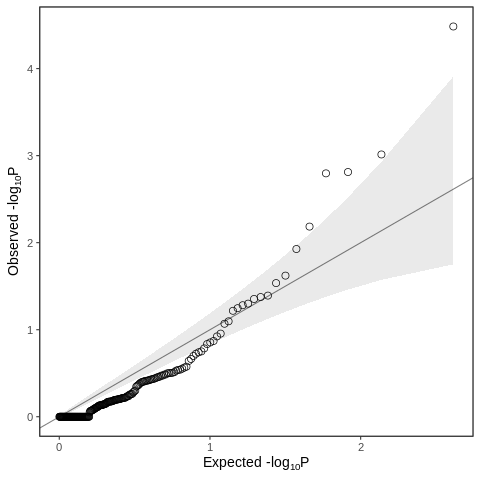

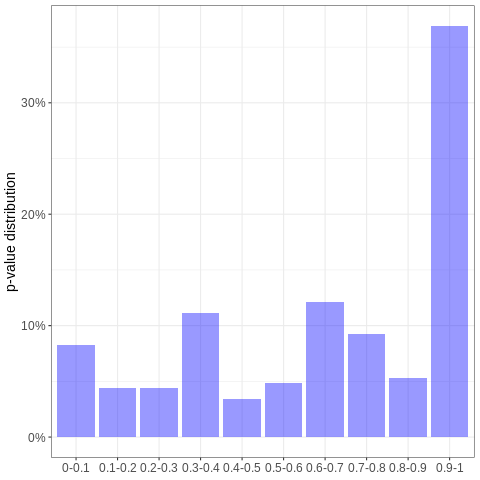

In [12]:
%%R

# Load data: CDSs are split on 2 intervals. All variants
bins2_all <- read.csv('./VarCount/G2Ph_bins2_all.csv', sep=',', header=T)

# Fisher's exact test
bins2_all_FT <- fisher_b2(bins2_all)

# Plot results
plot_fisher(bins2_all_FT)

# Save results

write.csv(bins2_all_FT,"./VarCount/G2Ph_bins2_all_FT.csv", row.names = FALSE, quote = F)

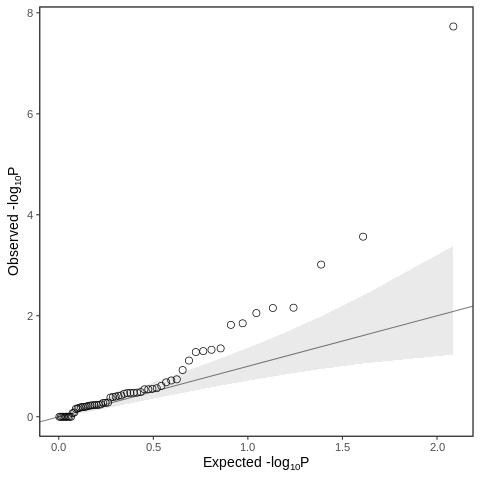

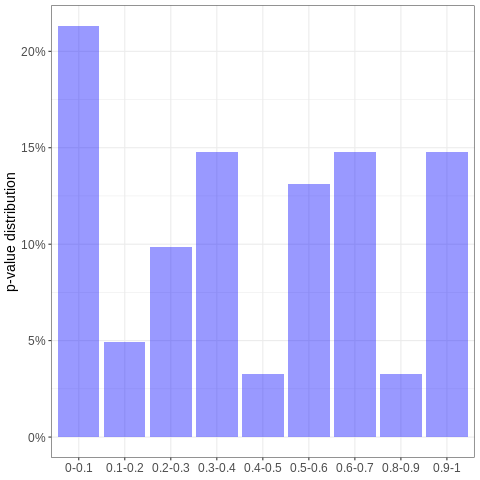

In [281]:
%%R

# Load data: CDSs are split on 2 intervals. wo pleiotropic variants
bins2_uniq <- read.csv('./VarCount/G2Ph_bins2_uniq.csv', sep=',', header=T)

# Fisher's exact test
bins2_uniq_FT <- fisher_b2(bins2_uniq)

# Plot results
plot_fisher(bins2_uniq_FT)

# Save results

write.csv(bins2_uniq_FT,"./VarCount/bins2_uniq_FT.csv", row.names = FALSE, quote = F)

##### Parse results of variant type distribution analysis

In [253]:
%%R

fisher_mp <- function(miss, plof){
    
    # merge 
    mp <- merge(miss, plof, by='Ensembl')
    mp <- mp[, c(1,2,4,3,5)]
    
    colnames(mp) <- c('Ensembl', 'd1_missense', 'd1_plof', 'd2_missense', 'd2_plof')
    mp$Ensembl <- as.character(mp$Ensembl)
    
    # filter results - rm genes with less than 5 associated variants per disease
    mp <- mp %>% filter((rowSums(mp[ , c(2,3)], na.rm=TRUE) >=5) & (rowSums(mp[ , c(4,5)], na.rm=TRUE) >=5))
    
    fisher_res <- data.frame(matrix(ncol=2, nrow=0))   
    colnames(fisher_res) <- c('Ensembl', 'p_value')
    
    # Fiher's exact test
    for (r in 1:nrow(mp)){   
        matr <- matrix(c(as.numeric(mp[r,2:ncol(mp)])),ncol=(ncol(mp)-1)/2, byrow=T)
        if (all(matr == 0)){   # exclude genes with no variants
            next
        }
        test <- fisher.test(matr,workspace = 2e8)
        fisher_res[nrow(fisher_res) + 1,] <- c(mp[r,1], as.numeric(test$p.value))   # add gene_id and p-value
    }
    df <- merge(fisher_res, mp, by='Ensembl', all.x = TRUE)
    
    # adjust p-value
    df$p_value <- as.numeric(df$p_value)   
    df$p_adj <-p.adjust(df$p_value, method = "fdr")
    df$log_pvalue <- -log10(as.numeric(df$p_value)) 
    df$log_padj <- -log10(as.numeric(df$p_adj)) 
    
 
    df <- df %>%
     mutate(pvalue_interval = case_when(
     p_value < 0.1 ~ "0-0.1", 
     p_value >= 0.1 & p_value < 0.2 ~ "0.1-0.2",
     p_value >= 0.2 & p_value < 0.3 ~ "0.2-0.3",
     p_value >= 0.3 & p_value < 0.4 ~ "0.3-0.4",
     p_value >= 0.4 & p_value < 0.5 ~ "0.4-0.5",
     p_value >= 0.5 & p_value < 0.6 ~ "0.5-0.6",
     p_value >= 0.6 & p_value < 0.7 ~ "0.6-0.7",
     p_value >= 0.7 & p_value < 0.8 ~ "0.7-0.8",
     p_value >= 0.8 & p_value < 0.9 ~ "0.8-0.9",
     p_value >= 0.9 ~ "0.9-1"))
    
    df$pvalue_interval <- as.factor(df$pvalue_interval)
    
    df <- df[ ,c(1,10,2,7,8,9,3,4,5,6)]
   
}

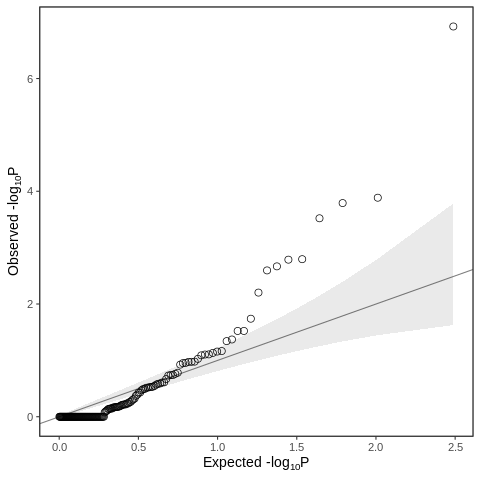

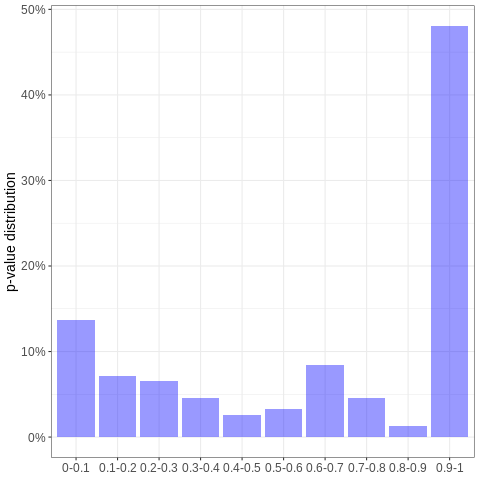

In [270]:
%%R

# Load data: Genes associated with 2 diseases. All variants

## missense 
miss_all <- read.csv('./VarCount/G2Ph_miss.csv', sep=',', header=T)

## pLOF
plof_all <- read.csv('./VarCount/G2Ph_plof.csv', sep=',', header=T)

# Fisher's exact test
mp_all_FT <- fisher_mp(miss_all, plof_all)

# Plot results
plot_fisher(mp_all_FT)

# Save results
write.csv(mp_all_FT,"./VarCount/G2Ph_missplof_FT", row.names = FALSE, quote = F)

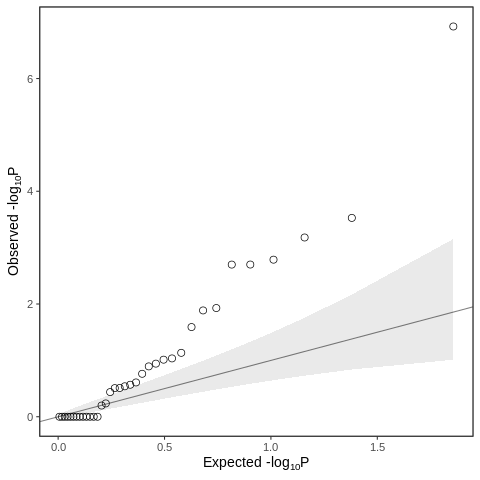

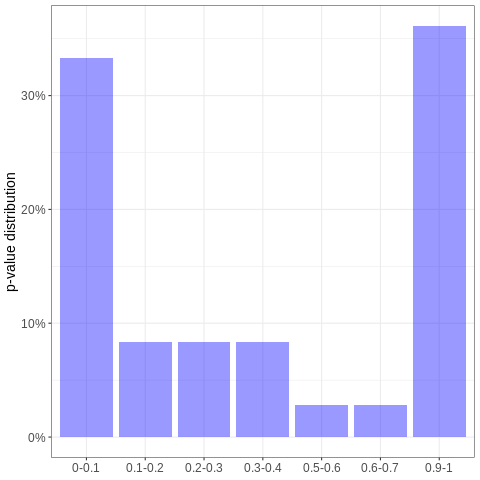

In [269]:
%%R

# Load data: Genes associated with 2 diseases. No pleiotropic variants
## missense 
miss_un <- read.csv('./VarCount/G2Ph_uniq_miss.csv', sep=',', header=T)

## pLOF
plof_un <- read.csv('./VarCount/G2Ph_uniq_plof.csv', sep=',', header=T)

# Fisher's exact test
mp_uniq_FT <- fisher_mp(miss_un, plof_un)

# Plot results
plot_fisher(mp_uniq_FT)

# Save results
write.csv(mp_uniq_FT,"./VarCount/G2Ph_missplof_uniq_FT.csv", row.names = FALSE, quote = F)

##  Collect all data in one dataframe

In [13]:
%%R

create_full_df <- function(fisher_res){
    # Inheritance info
    inh <- read.csv('./interm/Gene2Pheno_Inh.csv', sep='\t', header=TRUE)
    
    
    dis1 <- read.csv('./VarCount/G2Ph_dis1.csv',sep='\t', header=TRUE)
    dis2 <- read.csv('./VarCount/G2Ph_dis2.csv',sep='\t', header=TRUE)
    
    df_p1 <- list(fisher_res, inh, dis1, dis2)      
    
    df_p1 <- df_p1 %>% purrr::reduce(left_join, by='Ensembl')
    
    # pLI,loeuf
    gnmd <- read.csv('./data/gnomad.v2.1.1.pli_loeuf.txt', sep='\t',header=TRUE)
    
    df_p2 <- merge(df_p1, gnmd, by.x='GENE', by.y='gene', all.x=TRUE)
    
    # Simularity
    sim_score <- read.csv('./count_HPO/G2Ph_simscore.csv', sep=',', header=TRUE)
    
    df_info <- merge(df_p2, sim_score, by='GENE', all.x=TRUE)
    
}

In [291]:
%%R

bins5_all_info <- create_full_df(bins5_all_FT)

write.csv(bins5_all_info, './G2Ph_bins5_all_info.csv', row.names = FALSE, quote = F)

In [14]:
%%R

bins2_all_info <- create_full_df(bins2_all_FT)
write.csv(bins2_all_info, './G2Ph_bins2_all_info.csv', row.names = FALSE, quote = F)

In [298]:
%%R

bins5_uniq_info <- create_full_df(bins5_uniq_FT)
write.csv(bins5_uniq_info, './G2Ph_bins5_uniq_info.csv', row.names = FALSE, quote = F)

In [300]:
%%R

bins2_uniq_info <- create_full_df(bins2_uniq_FT)
write.csv(bins2_uniq_info, './G2Ph_bins2_uniq_info.csv', row.names = FALSE, quote = F)

In [303]:
%%R

mp_all_info <- create_full_df(mp_all_FT)
write.csv(mp_all_info, './G2Ph_missplof_all_info.csv', row.names = FALSE, quote = F)

In [302]:
%%R

mp_uniq_info <- create_full_df(mp_uniq_FT)
write.csv(mp_uniq_info, './G2Ph_missplof_uniq_info.csv', row.names = FALSE, quote = F)

##  Results.Plots

In [6]:
%%R

plots <- function(dat){
    
    dat <- dat %>%
     mutate(pvalue_class = case_when(
         p_value < 0.1 ~ "0-0.1", 
         p_value >= 0.1  ~ "0.1-1"
     ))
    
    pval_inh <- dat[ ,c('pvalue_class','Inh_class')]
    pval_inh <- pval_inh%>%
       group_by(pvalue_class,Inh_class) %>%
       summarize(count = n()) %>%
       mutate(prop = (count/sum(count)))
    
    
    # variant location - inheritance pattern
    pval_inh_bar <- ggplot(pval_inh, aes(y=prop, x=pvalue_class, label=count, fill=factor(Inh_class))) +
    geom_bar(position="stack", stat="identity")+ theme_bw() + 
    theme(axis.text = element_text(size = 12), axis.title =  element_text(size=14), 
    legend.text=element_text(size=14)) +  xlab('pvalue interval') +  ylab(NULL) + 
    scale_y_continuous(labels = percent_format()) + geom_text(size = 4, position = position_stack(vjust = 0.5))
    
    pval_inh_bar <- pval_inh_bar + guides(fill=guide_legend(title=NULL, nrow=2, byrow=TRUE)) + theme(legend.position="bottom")
    pval_inh_bar <- pval_inh_bar + theme(aspect.ratio = 1/2)  + coord_flip() + scale_fill_brewer(palette = "RdBu")
    print(pval_inh_bar)
    
    
    # variant location - pLI
    
    dat <- dat %>% 
       mutate(pli_class = case_when(
       pLI <= 0.1 ~ 'pLOF tolerant (pLI <=0.1)',
       pLI >= 0.9 ~ 'pLOF intolerant (pLI >=0.9)',
       TRUE ~ 'intermediate tolerance'))
    
    pval_pli <- dat[ ,c('pvalue_class', 'pli_class')]
    
    pval_pli <- pval_pli%>%
       group_by(pvalue_class, pli_class) %>%
       summarize(count = n()) %>%
       mutate(prop = (count/sum(count)))
    
    pval_pli_bar <- ggplot(pval_pli, aes(y=prop, x=pvalue_class, label=count, 
                                    fill=factor(pli_class, levels=c("pLOF intolerant (pLI >=0.9)",
                                                           "intermediate tolerance",
                                                           "pLOF tolerant (pLI <=0.1)")))) +
    geom_bar(position="stack", stat="identity")+ theme_bw() + 
    theme(axis.text = element_text(size = 12), axis.title =  element_text(size=14), 
    legend.text=element_text(size=14)) + xlab('pvalue interval') +  ylab(NULL) + 
    scale_y_continuous(labels = percent_format()) + geom_text(size = 6, position = position_stack(vjust = 0.5))
    
    pval_pli_bar <- pval_pli_bar + guides(fill=guide_legend(title=NULL, nrow=2, byrow=TRUE)) + theme(legend.position="bottom") + scale_fill_brewer(palette = "RdBu")
    pval_pli_bar <- pval_pli_bar + theme(aspect.ratio = 1/2)  + coord_flip()
    print(pval_pli_bar)
    
    
    # variant location - HP similarity (for genes with 2 AD diseases)
    dat_flt <- dat[(dat$MIM1_terms >=5) & (dat$MIM2_terms >=5), ]   # rm samples with less than 5 HPO terms for each disease
    
    print(head(dat))
    print(nrow(dat_flt))
    
    
    pval_jacc_pl <- ggplot(na.omit(dat_flt[dat_flt$Inh_class=='2AD', ]), aes(x=pvalue_class, y=Jaccard)) + geom_violin(fill='blue', alpha=0.25, trim=FALSE) + theme_bw() + theme(axis.text = element_text(size = 10), axis.title =  element_text(size=14, face="bold")) + 
    xlab('p-value class') + ggtitle('HP simularity score of 2 diseases \n with AD inheritance accosiated with the same gene')
    pval_jacc_pl <- pval_jacc_pl + geom_boxplot(width=0.1)
    print(pval_jacc_pl)
    
    pval_dist_pl <- ggplot(na.omit(dat_flt[dat_flt$Inh_class=='2AD', ]), aes(x = pvalue_class, y=HP_distance)) + geom_violin(fill='blue', alpha=0.25, trim=FALSE) + theme_bw() + theme(axis.text = element_text(size = 10), axis.title =  element_text(size=14, face="bold")) + 
    xlab('p-value class') + ggtitle('HP simularity score of 2 diseases \n with AD inheritance accosiated with the same gene')
    pval_dist_pl <- pval_dist_pl + geom_boxplot(width=0.1)
    print(pval_dist_pl)
    
    pval_res_pl <- ggplot(na.omit(dat_flt[dat_flt$Inh_class=='2AD', ]), aes(x = pvalue_class, y=Resnik)) + geom_violin(fill='blue', alpha=0.25, trim=FALSE) + theme_bw() + theme(axis.text = element_text(size = 10), axis.title =  element_text(size=14, face="bold")) + 
    xlab('p-value class') + ggtitle('HP simularity score of 2 diseases \n with AD inheritance accosiated with the same gene')
    pval_res_pl <- pval_res_pl + geom_boxplot(width=0.1)
    print(pval_res_pl)
   
}

`summarise()` has grouped output by 'pvalue_class'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'pvalue_class'. You can override using the
`.groups` argument.
    GENE         Ensembl pvalue_interval   p_value  log_pvalue p_adj log_padj
1  ABCA1 ENSG00000165029           0.9-1 1.0000000 0.000000000     1        0
2 ABCA12 ENSG00000144452         0.8-0.9 0.8898601 0.050678246     1        0
3 ABCB11 ENSG00000073734         0.2-0.3 0.2582636 0.587936830     1        0
4  ACTG1 ENSG00000184009         0.3-0.4 0.3874629 0.411769927     1        0
5  ACTG2 ENSG00000163017           0.9-1 1.0000000 0.000000000     1        0
6   ADA2 ENSG00000093072           0.9-1 0.9851659 0.006490621     1        0
  d1_1 d1_2 d1_3 d1_4 d1_5 d2_1 d2_2 d2_3 d2_4 d2_5 Inh_class      OMIM.x
1    1    2    5    4    0    1    1    2    1    0      ADAR OMIM:205400
2    3    2    3    0    1    1    1    4    0    1       2AR OMIM:242500
3    8    7    5    9    1    0   

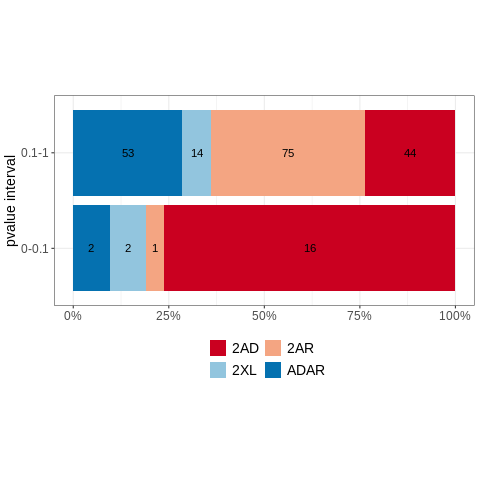

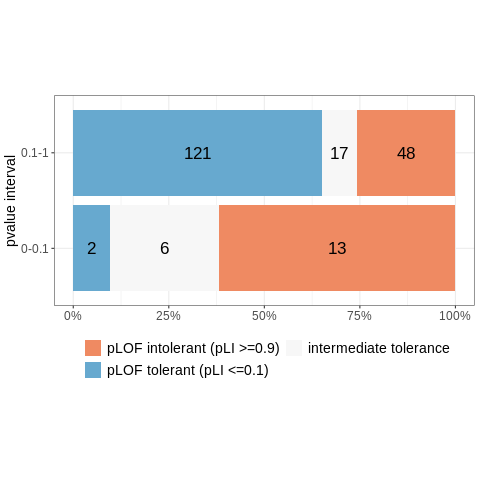

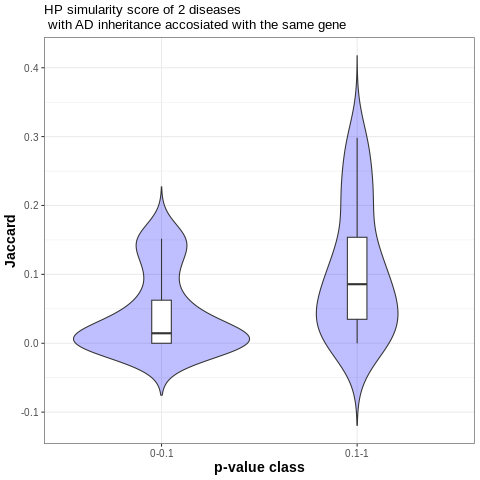

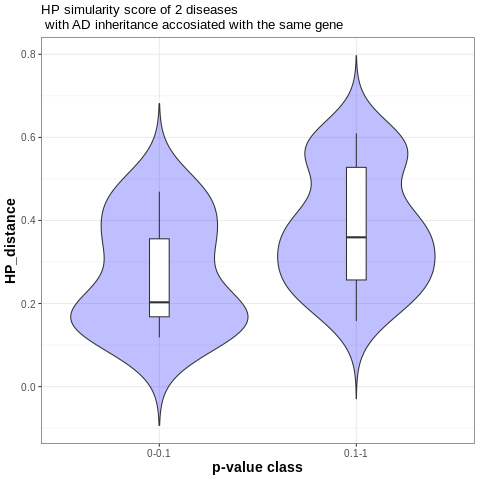

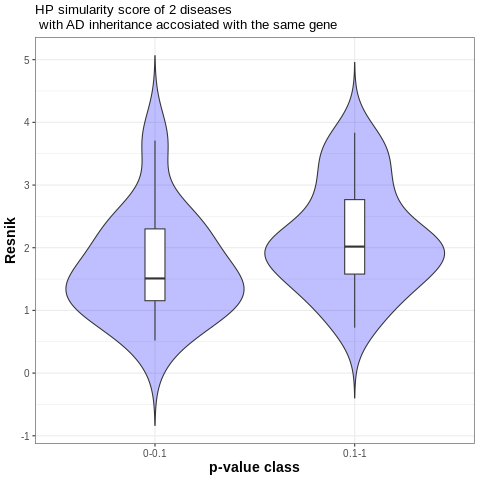

In [314]:
%%R

bins5_all_info <- read.csv('./G2Ph_bins5_all_info.csv', sep=',', header=TRUE)
plots(bins5_all_info)

`summarise()` has grouped output by 'pvalue_class'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'pvalue_class'. You can override using the
`.groups` argument.
    GENE         Ensembl pvalue_interval   p_value p_adj log_pvalue log_padj
1  ABCA1 ENSG00000165029         0.2-0.3 0.2800582     1  0.5527517        0
2 ABCA12 ENSG00000144452         0.5-0.6 0.5846154     1  0.2331298        0
3 ABCB11 ENSG00000073734           0.9-1 1.0000000     1  0.0000000        0
4  ACTG1 ENSG00000184009           0.9-1 1.0000000     1  0.0000000        0
5  ACTG2 ENSG00000163017         0.6-0.7 0.6700274     1  0.1739075        0
6   ADA2 ENSG00000093072           0.9-1 1.0000000     1  0.0000000        0
  d1_1 d1_2 d2_1 d2_2 Inh_class      OMIM.x      OMIM.y        pLI oe_lof_upper
1    3    9    3    2      ADAR OMIM:205400 OMIM:604091 1.4525e-13        0.486
2    6    3    6    1       2AR OMIM:242500 OMIM:601277 2.9220e-15        0.478
3   17   13    5    4  

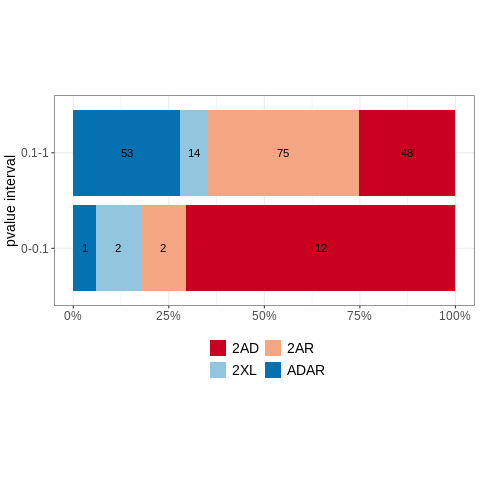

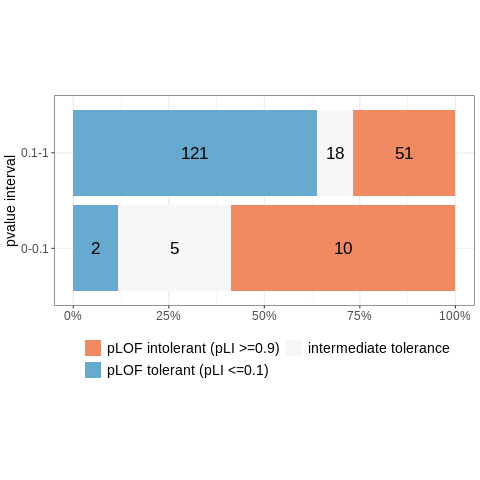

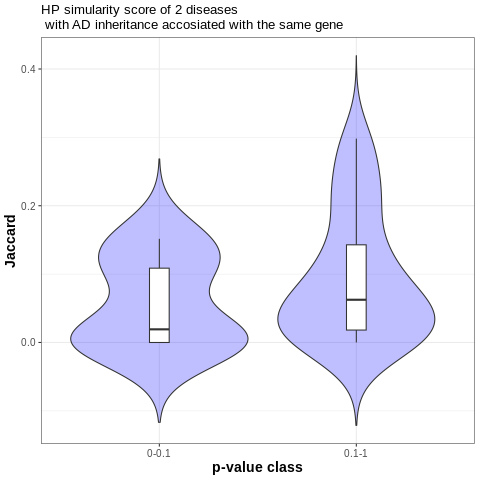

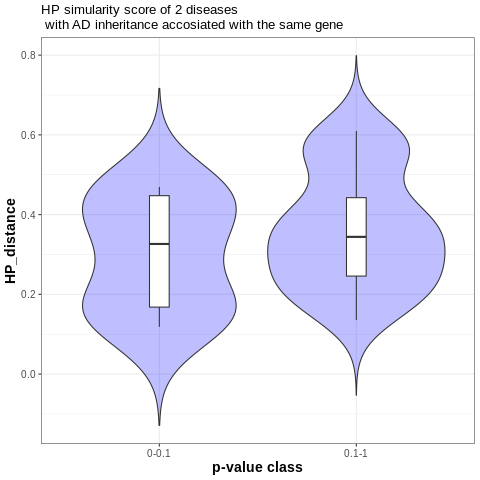

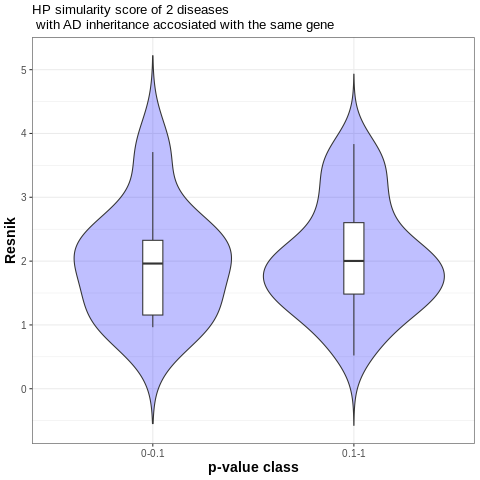

In [329]:
%%R


bins2_all_info <- read.csv('./G2Ph_bins2_all_info.csv', sep=',', header=TRUE)
plots(bins2_all_info)

`summarise()` has grouped output by 'pvalue_class'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'pvalue_class'. You can override using the
`.groups` argument.
     GENE         Ensembl pvalue_interval    p_value log_pvalue     p_adj
1   ABCA1 ENSG00000165029           0.9-1 1.00000000  0.0000000 1.0000000
2   ACTG1 ENSG00000184009         0.1-0.2 0.17132867  0.7661700 0.3772905
3    ADAR ENSG00000160710         0.6-0.7 0.64520773  0.1903004 0.8928303
4   ASAH1 ENSG00000104763           0-0.1 0.07269687  1.1384843 0.2190331
5 ATP13A2 ENSG00000159363           0-0.1 0.02909590  1.5361681 0.1271078
6  ATP1A1 ENSG00000163399           0-0.1 0.01587302  1.7993405 0.1111111
    log_padj d1_1 d1_2 d1_3 d1_4 d1_5 d2_1 d2_2 d2_3 d2_4 d2_5 Inh_class
1 0.00000000    1    2    5    4    0    1    1    2    1    0      ADAR
2 0.42332418    2    2    0    3    0    1    0    3    1    1       2AD
3 0.04923106    1    2    1    2    1    4    4    1    1    0   

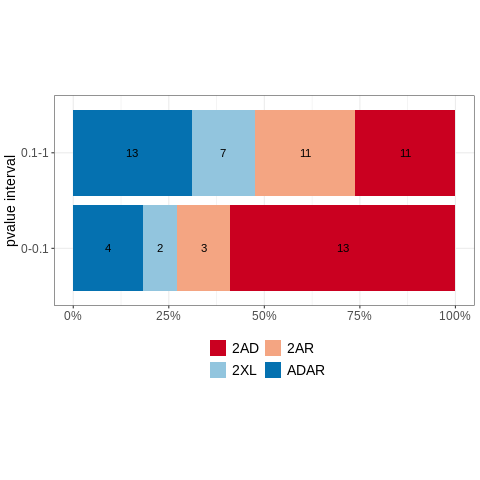

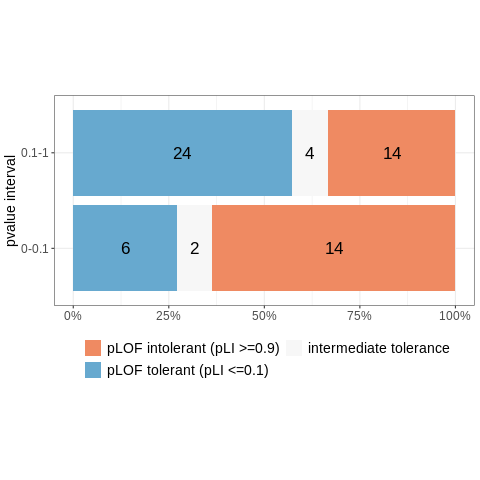

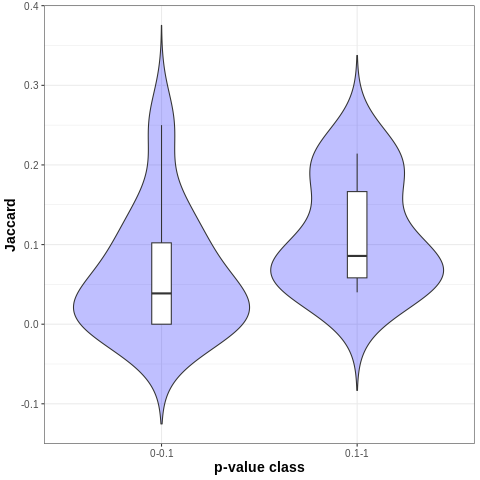

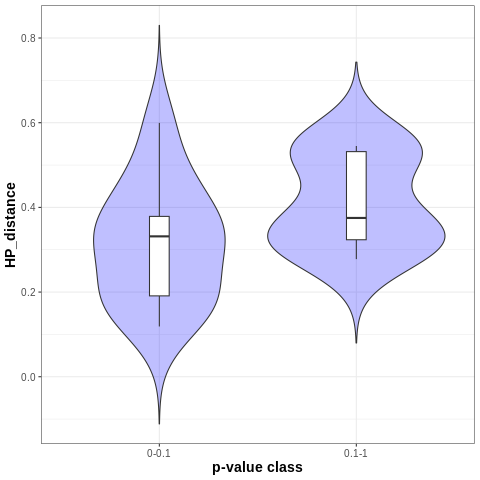

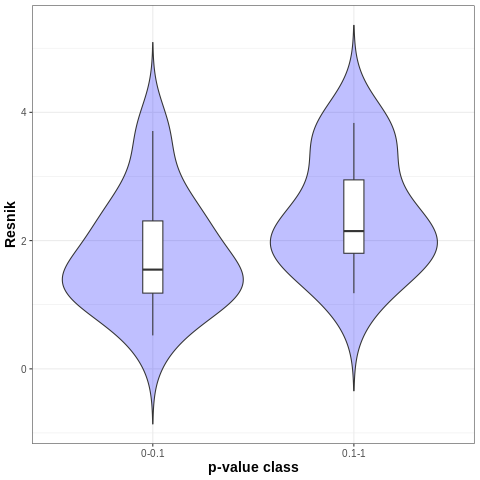

In [307]:
%%R

bins5_uniq_info <- read.csv('./G2Ph_bins5_uniq_info.csv', sep=',', header=TRUE)
plots(bins5_uniq_info)

`summarise()` has grouped output by 'pvalue_class'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'pvalue_class'. You can override using the
`.groups` argument.
     GENE         Ensembl pvalue_interval   p_value     p_adj log_pvalue
1   ABCA1 ENSG00000165029         0.2-0.3 0.2800582 0.7624104  0.5527517
2   ACTG1 ENSG00000184009           0.9-1 1.0000000 1.0000000  0.0000000
3    ADAR ENSG00000160710         0.5-0.6 0.5927602 0.8401147  0.2271210
4   ASAH1 ENSG00000104763           0.9-1 1.0000000 1.0000000  0.0000000
5 ATP13A2 ENSG00000159363         0.1-0.2 0.1188811 0.5179820  0.9248871
6  ATP1A1 ENSG00000163399         0.5-0.6 0.5238095 0.8401147  0.2808266
   log_padj d1_1 d1_2 d2_1 d2_2 Inh_class      OMIM.x      OMIM.y        pLI
1 0.1178112    3    9    3    2      ADAR OMIM:205400 OMIM:604091 1.4525e-13
2 0.0000000    4    3    3    3       2AD OMIM:604717 OMIM:614583 4.7837e-03
3 0.0756614    4    3    8    2      ADAR OMIM:127400 OMIM:6

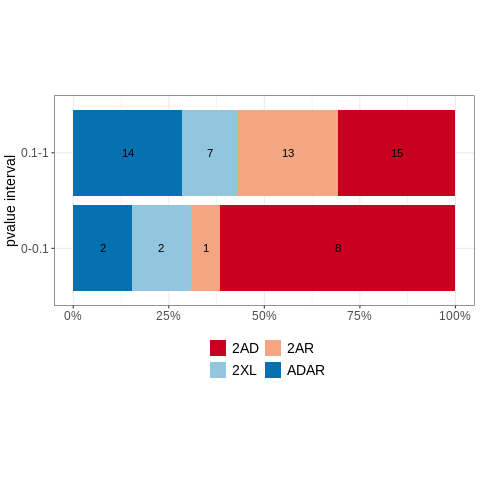

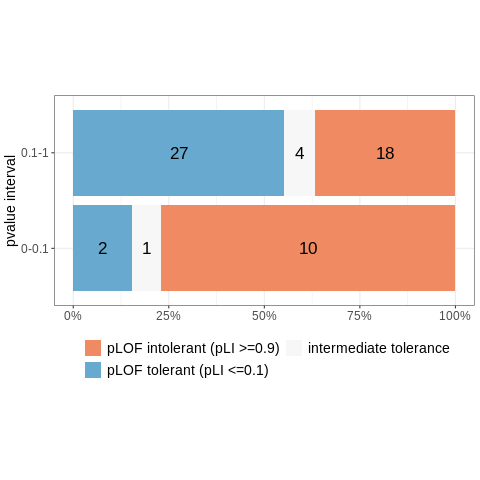

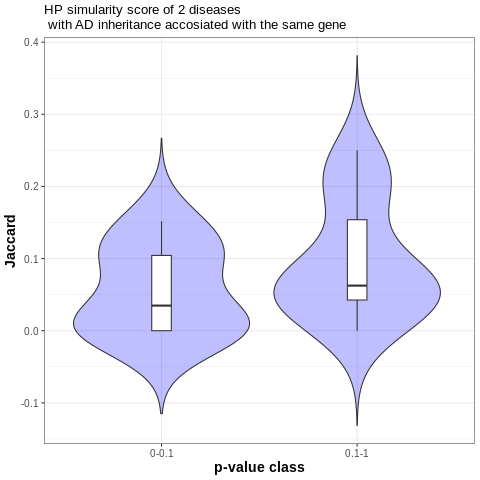

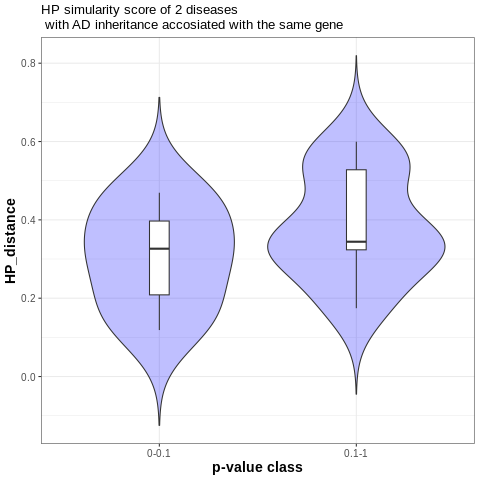

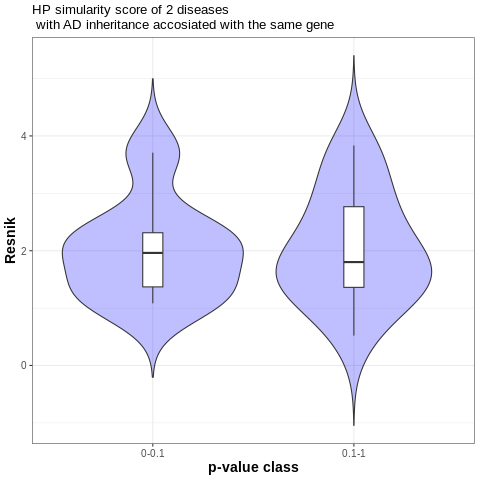

In [315]:
%%R

bins2_uniq_info <- read.csv('./G2Ph_bins2_uniq_info.csv', sep=',', header=TRUE)
plots(bins2_uniq_info)

`summarise()` has grouped output by 'pvalue_class'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'pvalue_class'. You can override using the
`.groups` argument.
      GENE         Ensembl pvalue_interval   p_value     p_adj log_pvalue
1   ABCA12 ENSG00000144452         0.1-0.2 0.1818182 0.8951505  0.7403627
2   ABCB11 ENSG00000073734         0.6-0.7 0.6662346 1.0000000  0.1763728
3    ACTG1 ENSG00000184009           0.9-1 1.0000000 1.0000000  0.0000000
4    ACTG2 ENSG00000163017           0.9-1 1.0000000 1.0000000  0.0000000
5     ADA2 ENSG00000093072         0.5-0.6 0.5134093 1.0000000  0.2895363
6 ADAMTSL4 ENSG00000143382           0.9-1 1.0000000 1.0000000  0.0000000
    log_padj d1_missense d1_plof d2_missense d2_plof Inh_class      OMIM.x
1 0.04810395           3       3           5       0       2AR OMIM:242500
2 0.00000000          16       6           5       3       2AR OMIM:601847
3 0.00000000          12       0          11       0       

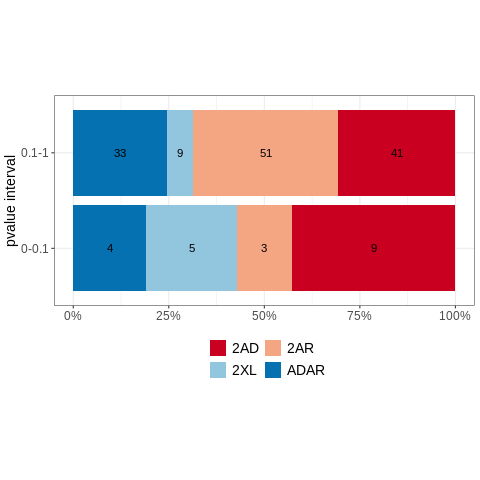

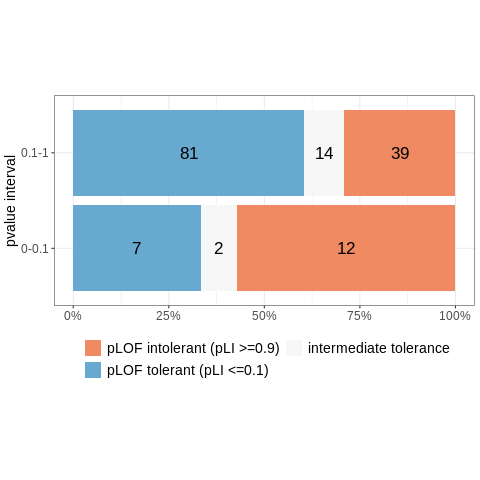

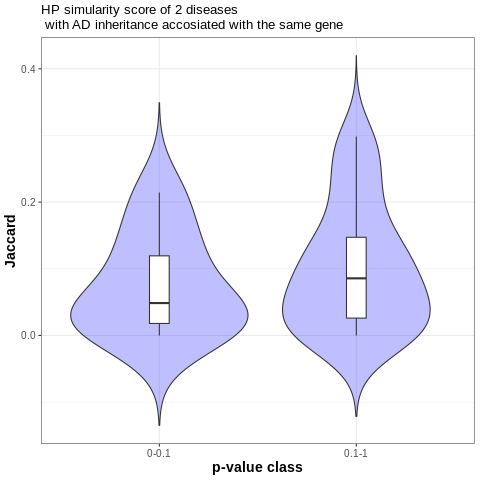

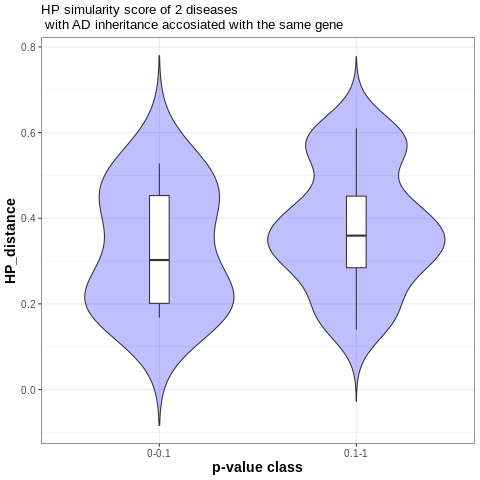

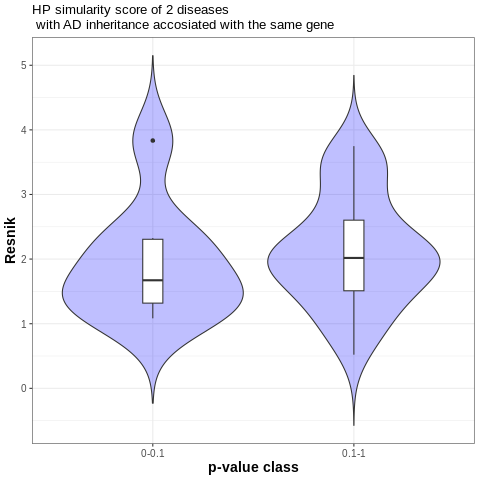

In [10]:
%%R

missplof_all_info <- read.csv('./G2Ph_missplof_all_info.csv', sep=',', header=TRUE)
plots(missplof_all_info)

`summarise()` has grouped output by 'pvalue_class'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'pvalue_class'. You can override using the
`.groups` argument.
    GENE         Ensembl pvalue_interval      p_value       p_adj log_pvalue
1  ACTG1 ENSG00000184009           0.9-1 1.0000000000 1.000000000  0.0000000
2 ATP1A1 ENSG00000163399           0.9-1 1.0000000000 1.000000000  0.0000000
3   ATRX ENSG00000085224         0.3-0.4 0.3088782562 0.559398496  0.5102127
4    BTK ENSG00000010671         0.6-0.7 0.6325851028 0.990133204  0.1988810
5 COL4A4 ENSG00000081052         0.3-0.4 0.3107769424 0.559398496  0.5075512
6 CREBBP ENSG00000005339           0-0.1 0.0006604085 0.007924902  3.1801873
     log_padj d1_missense d1_plof d2_missense d2_plof Inh_class      OMIM.x
1 0.000000000           7       0           6       0       2AD OMIM:604717
2 0.000000000           5       0           5       0       2AD OMIM:618036
3 0.252278705          12       5  

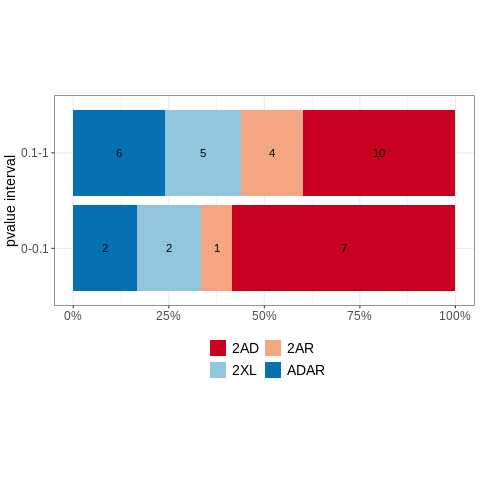

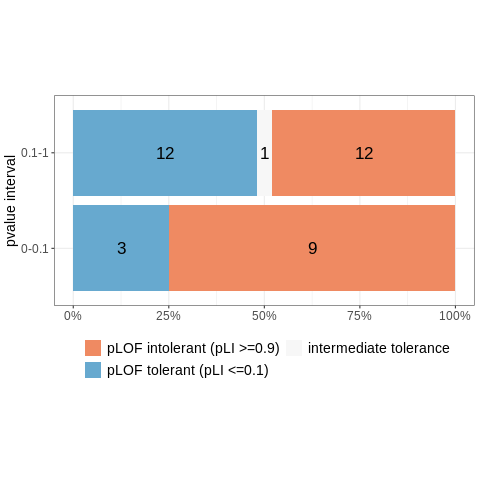

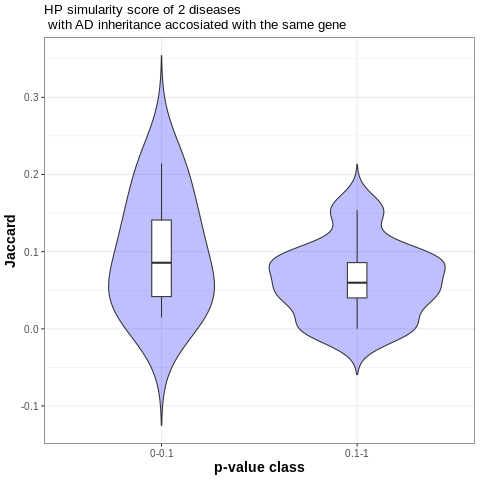

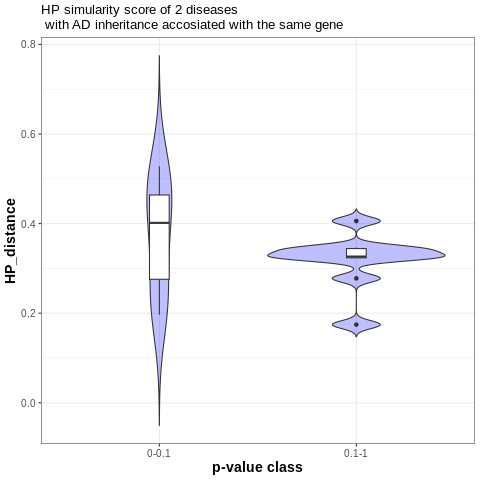

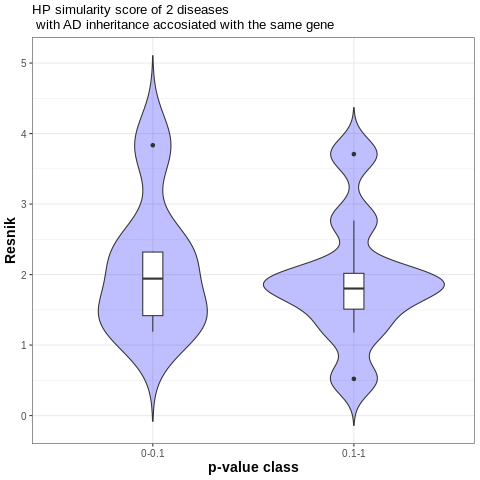

In [32]:
%%R

missplof_uniq_info <- read.csv('./G2Ph_missplof_uniq_info.csv', sep=',', header=TRUE)
plots(missplof_uniq_info)